In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/echonet-dynamic/EchoNet-Dynamic/FileList.csv
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/VolumeTracings.csv
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X6C96589B41EBA3C5.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X7630DA7B2D3E6F27.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X35FEF9072E3537BB.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0XCEEA1EA058DA6C0.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X10B7505562B0A702.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X4868DEBC55A12E1B.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X356662E85B788616.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X31AC494B44342BAE.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X12CF33089E2618A8.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X2BDF20FFCF3D29F8.avi
/kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos/0X68C1CD733690A87A.avi
/kaggle/input/echonet-dynamic/EchoNet-Dyn

In [2]:
import torch

print(f"CUDA disponible ? {torch.cuda.is_available()}")
print(f"Version PyTorch : {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU : {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU : {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("❌ CUDA non disponible - Le modèle utilisera le CPU")
    print("→ Activez le GPU dans Kaggle : Accelerator → GPU P100")

CUDA disponible ? True
Version PyTorch : 2.6.0+cu124
GPU : Tesla T4
Mémoire GPU : 15.83 GB


ANALYSE DÉTAILLÉE DE VolumeTracings.csv

📊 STATISTIQUES GLOBALES
   Total de points de segmentation: 425,010
   Colonnes: ['FileName', 'X1', 'Y1', 'X2', 'Y2', 'Frame']

                 FileName         X1         Y1         X2         Y2  Frame
0  0X100009310A3BD7FC.avi  51.260417  15.348958  64.932292  69.125000     46
1  0X100009310A3BD7FC.avi  50.037611  17.167841  53.367222  16.321330     46
2  0X100009310A3BD7FC.avi  49.157378  20.407629  57.090549  18.390722     46
3  0X100009310A3BD7FC.avi  48.538173  23.581055  59.997339  20.667707     46
4  0X100009310A3BD7FC.avi  47.918968  26.754480  62.904129  22.944693     46
5  0X100009310A3BD7FC.avi  47.962105  29.759513  65.810920  25.221679     46
6  0X100009310A3BD7FC.avi  48.167915  32.723188  68.247043  27.618326     46
7  0X100009310A3BD7FC.avi  48.373726  35.686864  70.385311  30.090698     46
8  0X100009310A3BD7FC.avi  48.579537  38.650539  72.523579  32.563071     46
9  0X100009310A3BD7FC.avi  49.014039  41.556073  74.151644  3

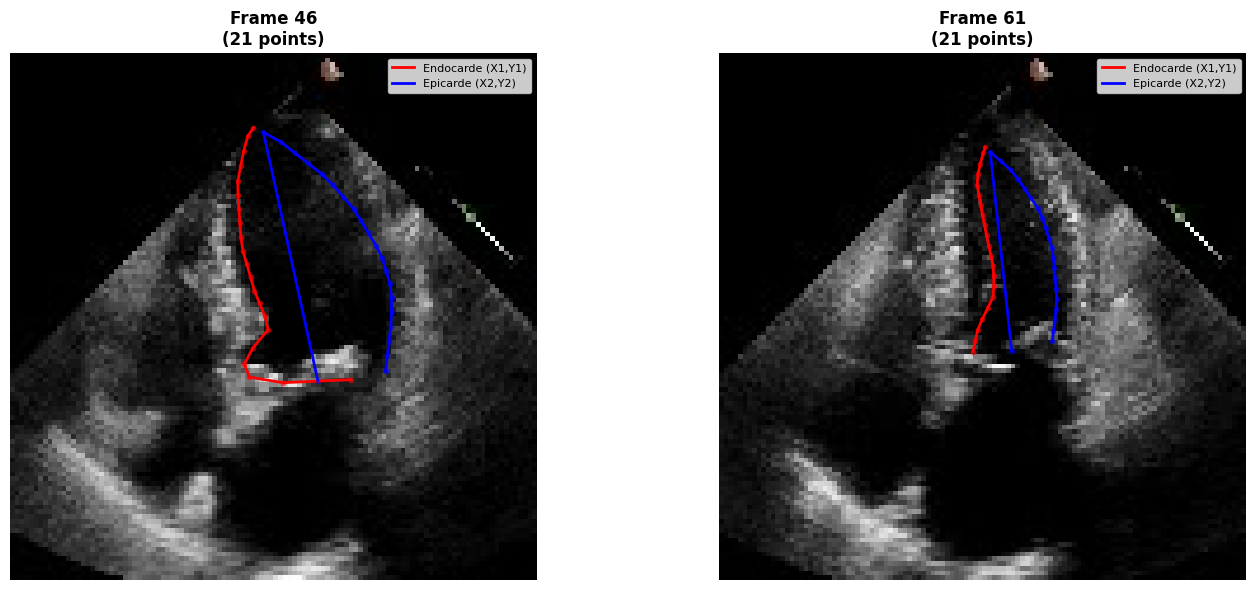


DÉMONSTRATION: CRÉATION D'UN MASQUE BINAIRE

✓ Masque créé:
   • Shape: (112, 112)
   • Pixels à 1 (ventricule): 678 (5.4%)
   • Pixels à 0 (background): 11866
✓ Sauvegardé: mask_creation_demo.png


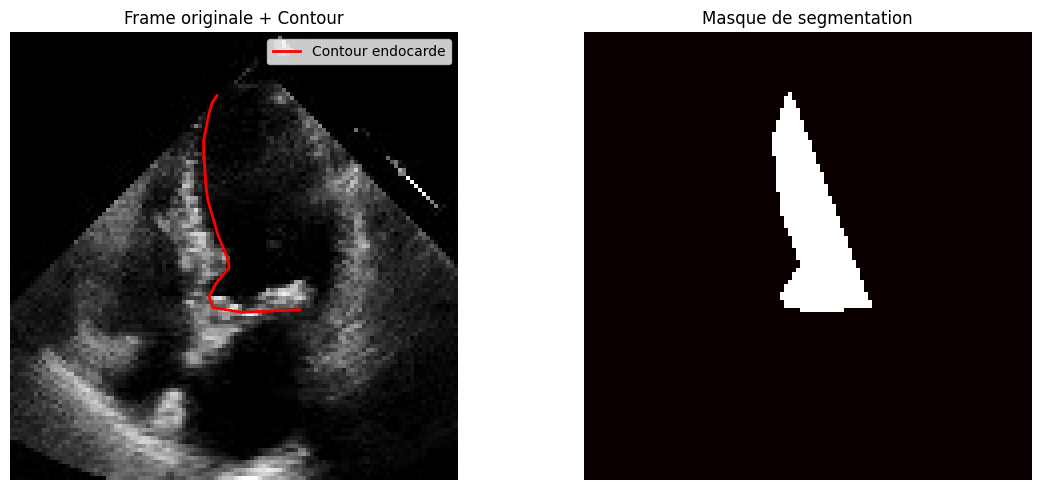


RÉSUMÉ DES DÉCOUVERTES

📊 STRUCTURE DES DONNÉES VolumeTracings.csv:

1️⃣ COUVERTURE:
   • 10,025 vidéos sur 10,030 ont des segmentations (100.0%)
   • Moyenne de 2.0 frames annotées par vidéo
   • Médiane: 2 frames

2️⃣ FRAMES ANNOTÉES:
   • Généralement 2 frames par vidéo (ES et ED)
   • Ces frames correspondent aux moments clés du cycle cardiaque
   • Moyenne de 21 points par frame

3️⃣ FORMAT DES CONTOURS:
   • X1, Y1 = Contour ENDOCARDE (paroi interne, crucial pour ESV/EDV)
   • X2, Y2 = Contour EPICARDE (paroi externe, moins utilisé)
   • Les points forment des polygones fermés

4️⃣ UTILISATION POUR LE MODÈLE:
   ✓ Peut servir à créer des masques de segmentation
   ✓ Permet de localiser précisément le ventricule gauche
   ✓ Utile pour l'attention spatiale ou la régularisation
   ✓ Améliore l'interprétabilité du modèle

5️⃣ LIMITES:
   ⚠️  Seulement ~100% des vidéos ont des segmentations
   ⚠️  Seulement 2 frames annotées par vidéo (pas tout le cycle)
   ⚠️  Nécessite interpolatio

In [2]:
"""
ANALYSE APPROFONDIE DU FICHIER VolumeTracings.csv
Objectif: Comprendre la structure des segmentations manuelles
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# ============================================================================
# 1. CHARGEMENT ET ANALYSE STATISTIQUE
# ============================================================================
print("="*70)
print("ANALYSE DÉTAILLÉE DE VolumeTracings.csv")
print("="*70)

# Chemins
BASE_PATH = '/kaggle/input/echonet-dynamic/EchoNet-Dynamic'
VOLUMETRACINGS_PATH = os.path.join(BASE_PATH, 'VolumeTracings.csv')
VIDEO_PATH = os.path.join(BASE_PATH, 'Videos')
FILELIST_PATH = os.path.join(BASE_PATH, 'FileList.csv')

# Charger les données
volumetracings_df = pd.read_csv(VOLUMETRACINGS_PATH)
filelist_df = pd.read_csv(FILELIST_PATH)

print(f"\n📊 STATISTIQUES GLOBALES")
print(f"   Total de points de segmentation: {len(volumetracings_df):,}")
print(f"   Colonnes: {list(volumetracings_df.columns)}")
print(f"\n{volumetracings_df.head(10)}\n")

# ============================================================================
# 2. ANALYSE PAR VIDÉO
# ============================================================================
print("="*70)
print("ANALYSE PAR VIDÉO")
print("="*70)

# Grouper par vidéo
video_groups = volumetracings_df.groupby('FileName')

# Statistiques par vidéo
video_stats = pd.DataFrame({
    'nb_points': video_groups.size(),
    'nb_frames_annotees': video_groups['Frame'].nunique(),
    'frames_min': video_groups['Frame'].min(),
    'frames_max': video_groups['Frame'].max(),
    'points_par_frame_moyen': video_groups.size() / video_groups['Frame'].nunique()
})

print(f"\n📹 STATISTIQUES DES SEGMENTATIONS:")
print(f"   • Nombre de vidéos avec segmentations: {len(video_stats)}")
print(f"   • Nombre total de vidéos dans dataset: {len(filelist_df)}")
print(f"   • Pourcentage de vidéos segmentées: {len(video_stats)/len(filelist_df)*100:.1f}%\n")

print("📈 Distribution des frames annotées par vidéo:")
print(video_stats['nb_frames_annotees'].describe())
print()

print("📊 Distribution des points par vidéo:")
print(video_stats['nb_points'].describe())
print()

# ============================================================================
# 3. ANALYSE DÉTAILLÉE D'UNE VIDÉO EXEMPLE
# ============================================================================
print("="*70)
print("EXEMPLE DÉTAILLÉ: UNE VIDÉO AVEC SEGMENTATIONS")
print("="*70)

# Prendre la première vidéo comme exemple
exemple_filename = video_stats.index[0]
exemple_data = volumetracings_df[volumetracings_df['FileName'] == exemple_filename]

print(f"\n🎥 VIDÉO EXEMPLE: {exemple_filename}")
print(f"   • Nombre total de points: {len(exemple_data)}")
print(f"   • Frames annotées: {exemple_data['Frame'].nunique()}")
print(f"   • Liste des frames: {sorted(exemple_data['Frame'].unique())}")

# Informations de FileList
if exemple_filename in filelist_df['FileName'].values:
    video_info = filelist_df[filelist_df['FileName'] == exemple_filename].iloc[0]
    print(f"\n📋 INFORMATIONS DE LA VIDÉO:")
    print(f"   • Nombre total de frames: {video_info['NumberOfFrames']}")
    print(f"   • EF: {video_info['EF']:.2f}%")
    print(f"   • EDV: {video_info['EDV']:.2f} mL")
    print(f"   • ESV: {video_info['ESV']:.2f} mL")
    print(f"   • Label: {'Healthy' if video_info['EF'] >= 50 else 'Unhealthy'}")
    print(f"   • Split: {video_info['Split']}")

# Analyser une frame spécifique
frames_uniques = sorted(exemple_data['Frame'].unique())
frame_a_analyser = frames_uniques[0]  # Première frame annotée

frame_data = exemple_data[exemple_data['Frame'] == frame_a_analyser]

print(f"\n🔍 FRAME {frame_a_analyser} (première annotée):")
print(f"   • Nombre de points du contour: {len(frame_data)}")
print(f"   • Coordinates X1: min={frame_data['X1'].min():.1f}, max={frame_data['X1'].max():.1f}")
print(f"   • Coordinates Y1: min={frame_data['Y1'].min():.1f}, max={frame_data['Y1'].max():.1f}")
print(f"   • Coordinates X2: min={frame_data['X2'].min():.1f}, max={frame_data['X2'].max():.1f}")
print(f"   • Coordinates Y2: min={frame_data['Y2'].min():.1f}, max={frame_data['Y2'].max():.1f}")

print(f"\n📐 STRUCTURE DES DONNÉES:")
print("   X1, Y1 = Contour ENDOCARDE (paroi interne du ventricule gauche)")
print("   X2, Y2 = Contour EPICARDE (paroi externe du ventricule gauche)")
print("\n   → Chaque ligne = 1 point des 2 contours")
print("   → Les points forment des courbes fermées (polygones)")

# ============================================================================
# 4. VÉRIFICATION: FRAMES ES ET ED
# ============================================================================
print("\n" + "="*70)
print("VÉRIFICATION: FRAMES END-SYSTOLE (ES) ET END-DIASTOLE (ED)")
print("="*70)

# Les frames annotées sont généralement ES et ED (les 2 frames clés)
# ES = plus petit volume (contraction maximale)
# ED = plus grand volume (relaxation maximale)

print(f"\n💡 HYPOTHÈSE:")
print(f"   La plupart des vidéos devraient avoir 2 frames annotées:")
print(f"   - Frame ES (End-Systole): volume minimal")
print(f"   - Frame ED (End-Diastole): volume maximal")

print(f"\n📊 DISTRIBUTION DES FRAMES ANNOTÉES PAR VIDÉO:")
frames_count = video_stats['nb_frames_annotees'].value_counts().sort_index()
for nb_frames, count in frames_count.items():
    print(f"   • {int(nb_frames)} frame(s) annotée(s): {count} vidéos ({count/len(video_stats)*100:.1f}%)")

# ============================================================================
# 5. VISUALISATION D'UNE SEGMENTATION
# ============================================================================
print("\n" + "="*70)
print("VISUALISATION D'UNE SEGMENTATION")
print("="*70)

# Charger la vidéo exemple
video_path = os.path.join(VIDEO_PATH, exemple_filename)

if os.path.exists(video_path):
    print(f"\n✓ Chargement de la vidéo: {exemple_filename}")
    
    cap = cv2.VideoCapture(video_path)
    
    if cap.isOpened():
        # Récupérer les frames annotées
        frames_to_plot = sorted(exemple_data['Frame'].unique())[:2]  # 2 premières
        
        fig, axes = plt.subplots(1, len(frames_to_plot), figsize=(15, 6))
        if len(frames_to_plot) == 1:
            axes = [axes]
        
        for idx, frame_num in enumerate(frames_to_plot):
            # Lire la frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            
            if ret:
                # Convertir en RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Récupérer les points de segmentation
                frame_seg = exemple_data[exemple_data['Frame'] == frame_num]
                
                # Extraire les contours
                x1 = frame_seg['X1'].values
                y1 = frame_seg['Y1'].values
                x2 = frame_seg['X2'].values
                y2 = frame_seg['Y2'].values
                
                # Afficher
                axes[idx].imshow(frame_rgb)
                
                # Dessiner contour endocarde (intérieur) en ROUGE
                axes[idx].plot(x1, y1, 'r-', linewidth=2, label='Endocarde (X1,Y1)')
                axes[idx].scatter(x1, y1, c='red', s=10, alpha=0.5)
                
                # Dessiner contour épicarde (extérieur) en BLEU
                axes[idx].plot(x2, y2, 'b-', linewidth=2, label='Epicarde (X2,Y2)')
                axes[idx].scatter(x2, y2, c='blue', s=10, alpha=0.5)
                
                axes[idx].set_title(f'Frame {frame_num}\n({len(frame_seg)} points)', 
                                   fontsize=12, fontweight='bold')
                axes[idx].legend(loc='upper right', fontsize=8)
                axes[idx].axis('off')
        
        cap.release()
        
        plt.tight_layout()
        plt.savefig('segmentation_example_analysis.png', dpi=300, bbox_inches='tight')
        print("✓ Sauvegardé: segmentation_example_analysis.png")
        plt.show()
    else:
        print("❌ Impossible d'ouvrir la vidéo")
else:
    print(f"❌ Vidéo introuvable: {video_path}")

# ============================================================================
# 6. CRÉATION D'UN MASQUE DE SEGMENTATION
# ============================================================================
print("\n" + "="*70)
print("DÉMONSTRATION: CRÉATION D'UN MASQUE BINAIRE")
print("="*70)

def create_segmentation_mask(frame_seg_data, height=112, width=112):
    """
    Créer un masque binaire à partir des points de segmentation
    
    Args:
        frame_seg_data: DataFrame avec colonnes X1, Y1, X2, Y2
        height, width: Dimensions du masque
    
    Returns:
        mask: Masque binaire [H, W] où 1 = ventricule gauche
    """
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Extraire les points du contour intérieur (endocarde)
    points_endo = np.column_stack([
        frame_seg_data['X1'].values,
        frame_seg_data['Y1'].values
    ]).astype(np.int32)
    
    # Remplir le polygone
    cv2.fillPoly(mask, [points_endo], color=1)
    
    return mask

# Créer le masque pour la première frame annotée
frame_seg = exemple_data[exemple_data['Frame'] == frame_a_analyser]
mask = create_segmentation_mask(frame_seg, height=112, width=112)

print(f"\n✓ Masque créé:")
print(f"   • Shape: {mask.shape}")
print(f"   • Pixels à 1 (ventricule): {mask.sum()} ({mask.sum()/(112*112)*100:.1f}%)")
print(f"   • Pixels à 0 (background): {(mask==0).sum()}")

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Frame originale avec contours
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_a_analyser)
ret, frame = cap.read()
if ret:
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    axes[0].imshow(frame_gray, cmap='gray')
    
    # Superposer le contour
    x1 = frame_seg['X1'].values
    y1 = frame_seg['Y1'].values
    axes[0].plot(x1, y1, 'r-', linewidth=2, label='Contour endocarde')
    axes[0].set_title('Frame originale + Contour')
    axes[0].legend()
    axes[0].axis('off')

cap.release()

# Masque binaire
axes[1].imshow(mask, cmap='hot', interpolation='nearest')
axes[1].set_title('Masque de segmentation')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('mask_creation_demo.png', dpi=300, bbox_inches='tight')
print("✓ Sauvegardé: mask_creation_demo.png")
plt.show()

# ============================================================================
# 7. STATISTIQUES FINALES
# ============================================================================
print("\n" + "="*70)
print("RÉSUMÉ DES DÉCOUVERTES")
print("="*70)

print(f"""
📊 STRUCTURE DES DONNÉES VolumeTracings.csv:

1️⃣ COUVERTURE:
   • {len(video_stats):,} vidéos sur {len(filelist_df):,} ont des segmentations ({len(video_stats)/len(filelist_df)*100:.1f}%)
   • Moyenne de {video_stats['nb_frames_annotees'].mean():.1f} frames annotées par vidéo
   • Médiane: {video_stats['nb_frames_annotees'].median():.0f} frames

2️⃣ FRAMES ANNOTÉES:
   • Généralement 2 frames par vidéo (ES et ED)
   • Ces frames correspondent aux moments clés du cycle cardiaque
   • Moyenne de {video_stats['points_par_frame_moyen'].mean():.0f} points par frame

3️⃣ FORMAT DES CONTOURS:
   • X1, Y1 = Contour ENDOCARDE (paroi interne, crucial pour ESV/EDV)
   • X2, Y2 = Contour EPICARDE (paroi externe, moins utilisé)
   • Les points forment des polygones fermés

4️⃣ UTILISATION POUR LE MODÈLE:
   ✓ Peut servir à créer des masques de segmentation
   ✓ Permet de localiser précisément le ventricule gauche
   ✓ Utile pour l'attention spatiale ou la régularisation
   ✓ Améliore l'interprétabilité du modèle

5️⃣ LIMITES:
   ⚠️  Seulement ~{len(video_stats)/len(filelist_df)*100:.0f}% des vidéos ont des segmentations
   ⚠️  Seulement 2 frames annotées par vidéo (pas tout le cycle)
   ⚠️  Nécessite interpolation pour les frames non annotées
""")

print("="*70)

VÉRIFICATION DES CHEMINS DES DONNÉES
✓ Base Path: /kaggle/input/echonet-dynamic/EchoNet-Dynamic
✓ Videos Path: /kaggle/input/echonet-dynamic/EchoNet-Dynamic/Videos
✓ FileList Path: /kaggle/input/echonet-dynamic/EchoNet-Dynamic/FileList.csv
✓ Volume Tracings Path: /kaggle/input/echonet-dynamic/EchoNet-Dynamic/VolumeTracings.csv

Vérification de l'existence des fichiers:
  - FileList.csv existe: True
  - VolumeTracings.csv existe: True
  - Dossier Videos existe: True
  - Nombre de vidéos trouvées: 10030

CHARGEMENT DES DONNÉES
✓ FileList.csv chargé: 10030 lignes, 9 colonnes

Aperçu des données (5 premières lignes):
             FileName         EF         ESV         EDV  FrameHeight  \
0  0X100009310A3BD7FC  78.498406   14.881368   69.210534          112   
1  0X1002E8FBACD08477  59.101988   40.383876   98.742884          112   
2  0X1005D03EED19C65B  62.363798   14.267784   37.909734          112   
3  0X10075961BC11C88E  54.545097   33.143084   72.914210          112   
4  0X10094BA0A

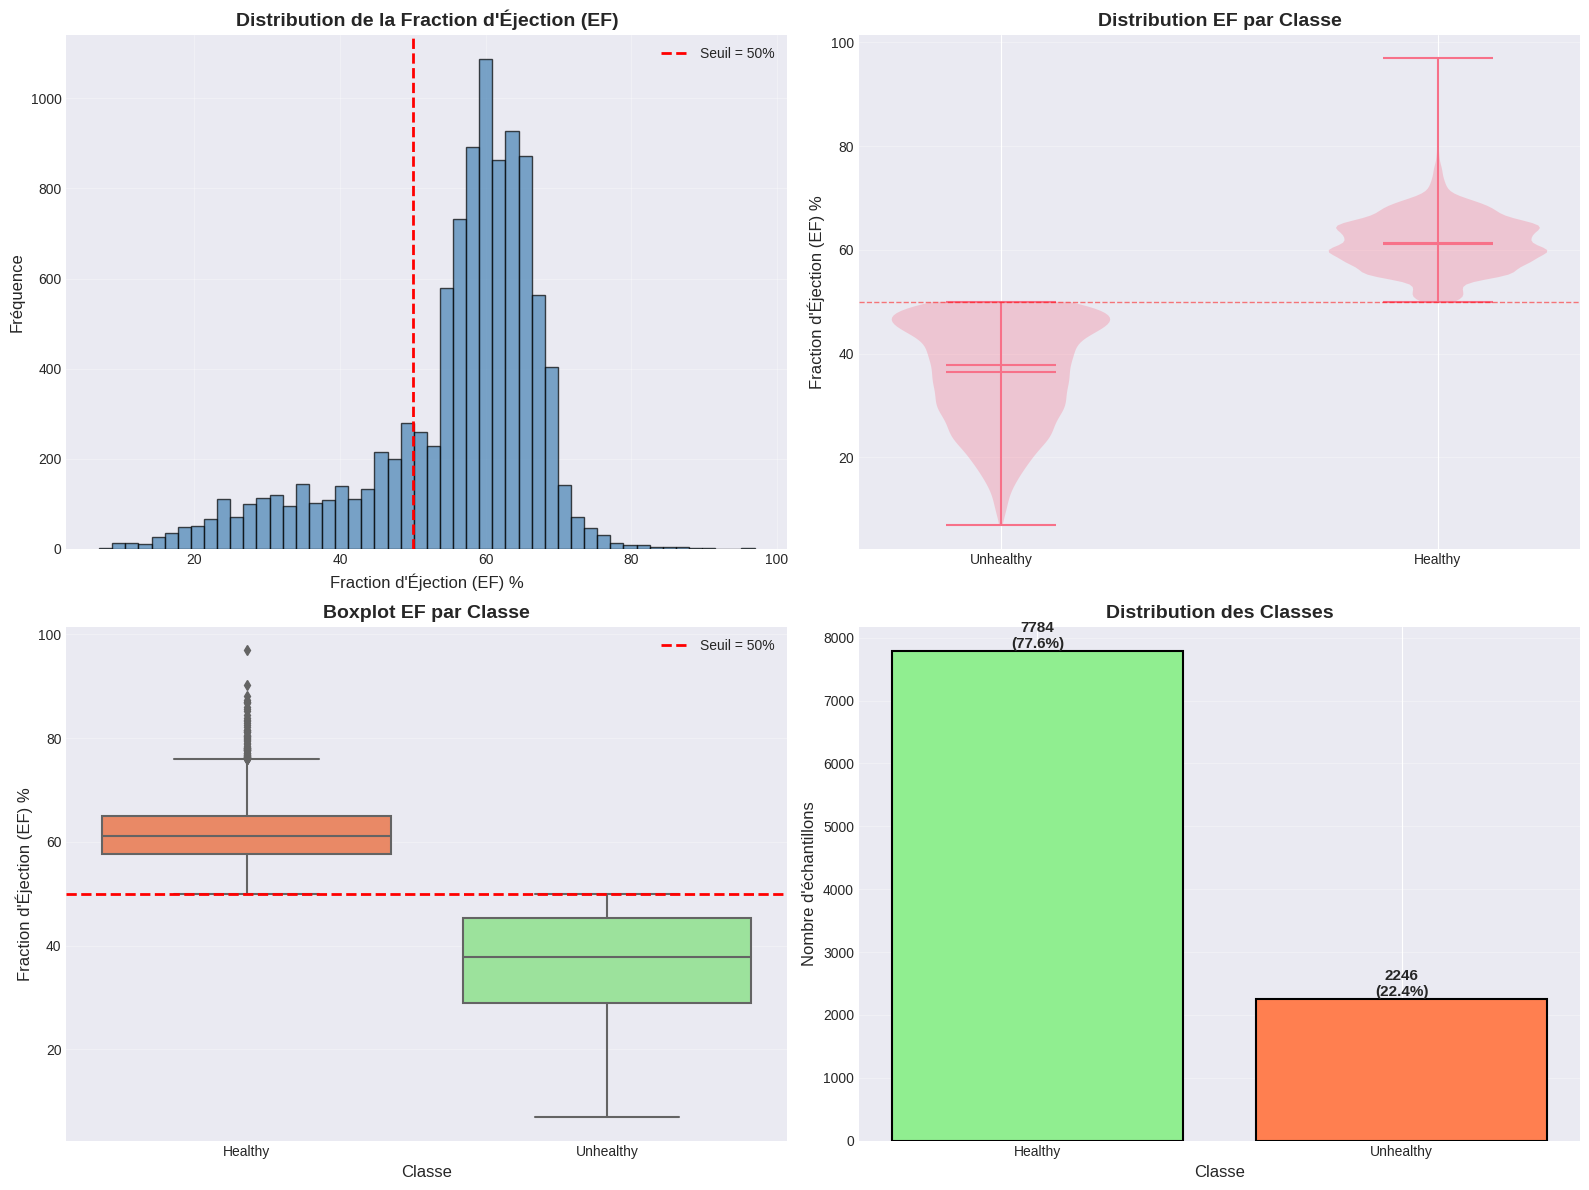

✓ Graphique sauvegardé: complementary_analysis.png


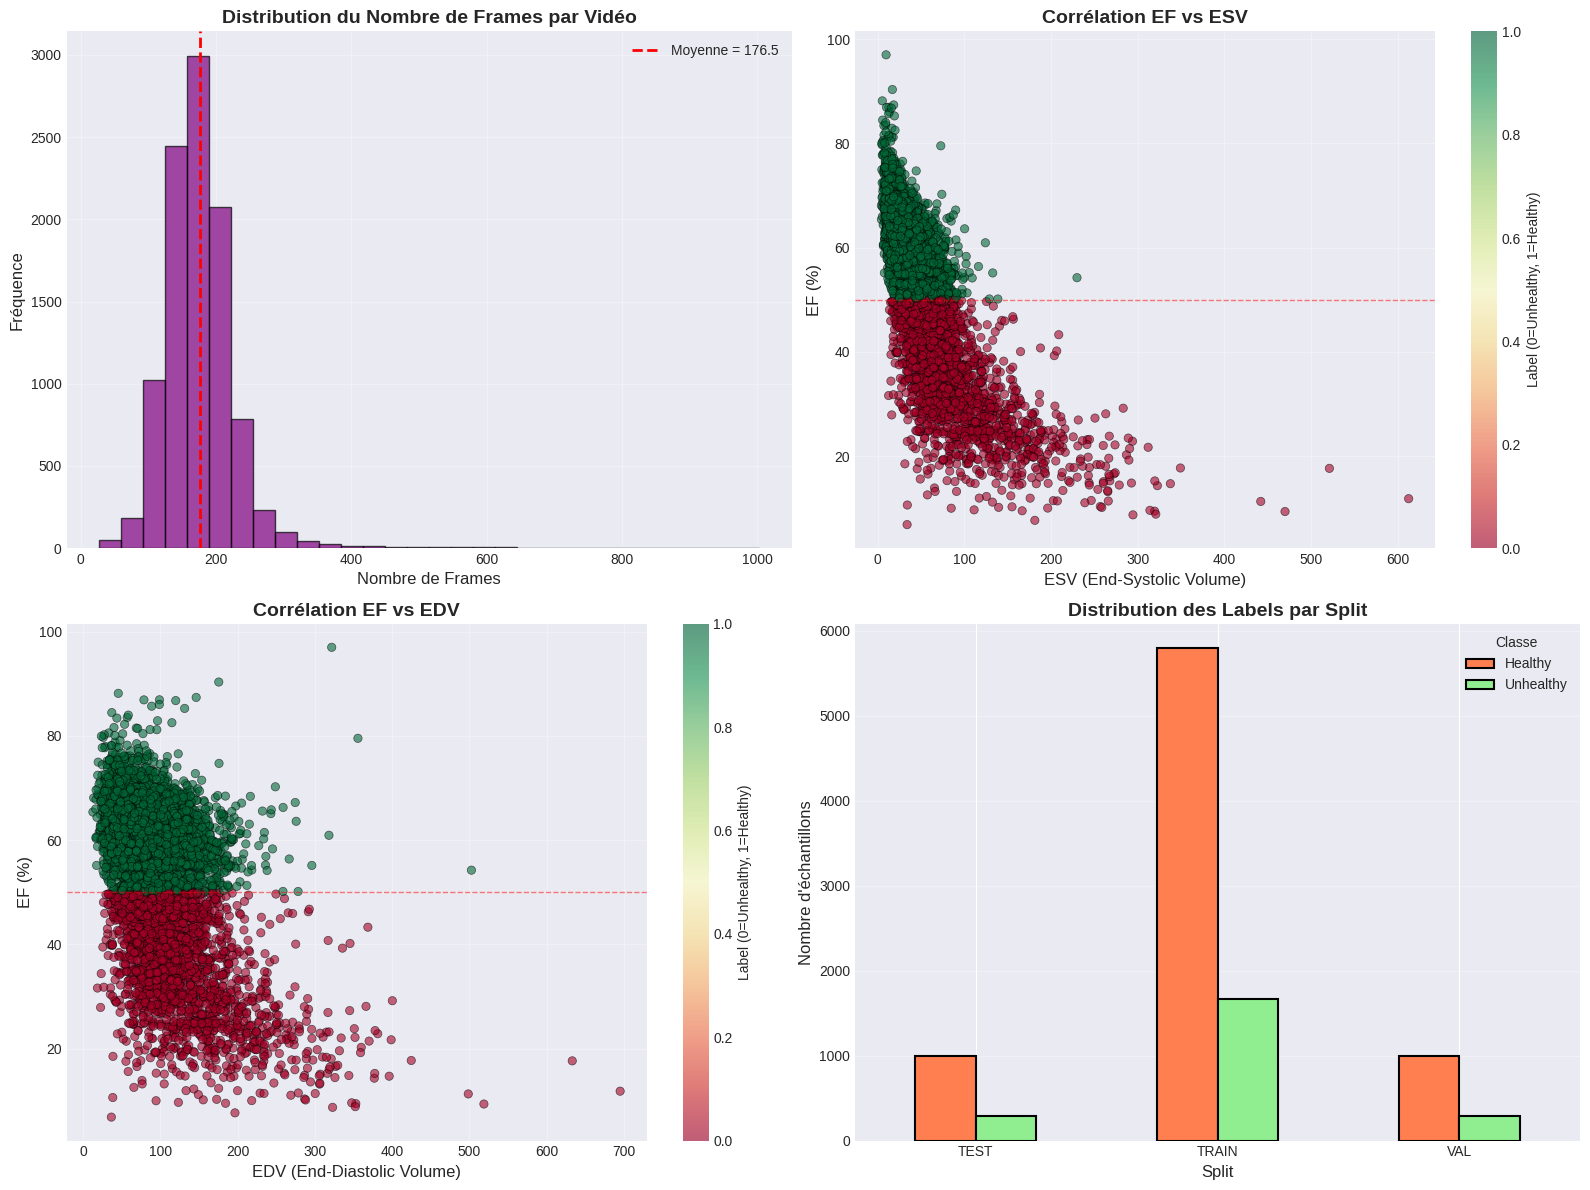

✓ Graphique sauvegardé: correlation_matrix.png


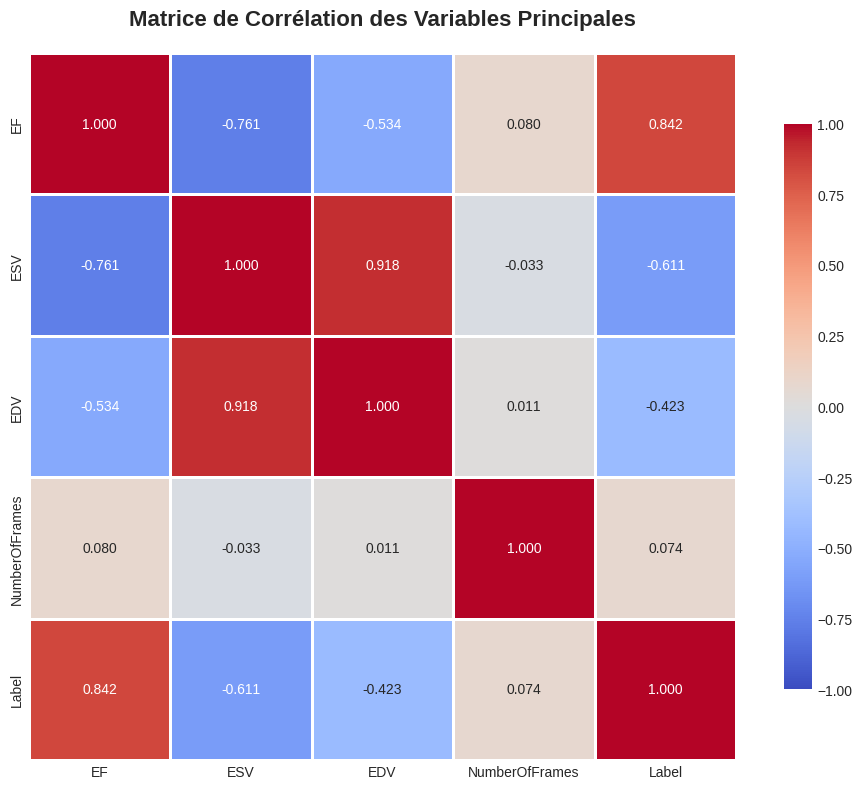


ANALYSE DES VIDÉOS - ÉCHANTILLON

Chargement de 3 échantillons HEALTHY...
Chargement de 3 échantillons UNHEALTHY...
✓ Graphique sauvegardé: video_samples_comparison.png


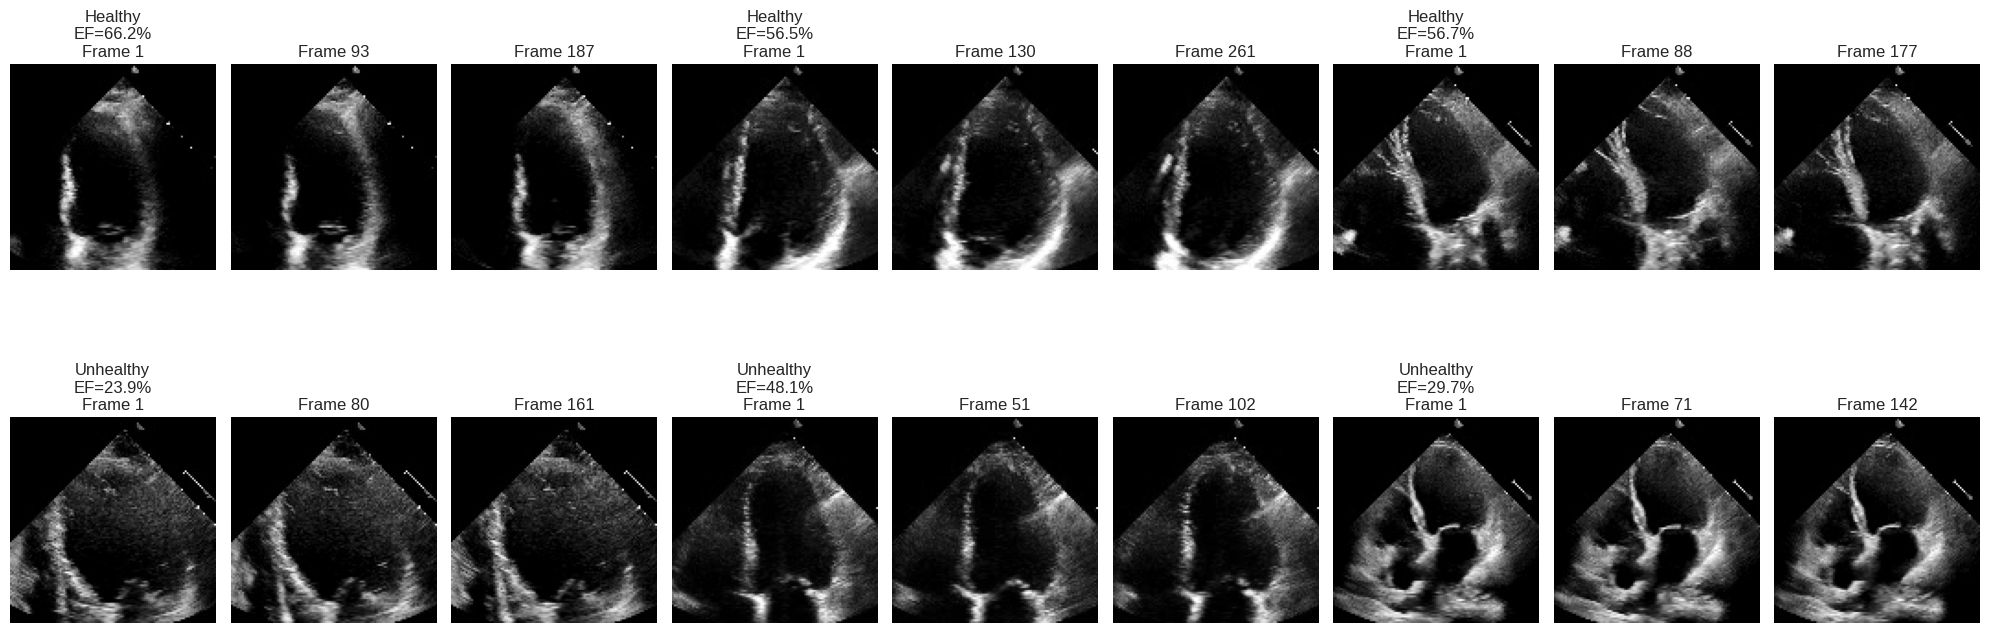


SAUVEGARDE DU DATASET ENRICHI
✓ Dataset enrichi sauvegardé: echonet_with_labels.csv
  Colonnes ajoutées: 'Label' et 'Label_Name'

RÉSUMÉ DE L'EXPLORATION DES DONNÉES

📊 DATASET:
   • Total échantillons: 10030
   • Healthy (EF >= 50%): 7784 (77.61%)
   • Unhealthy (EF < 50%): 2246 (22.39%)
   • Ratio déséquilibre: 3.47:1

📈 STATISTIQUES EF:
   • Moyenne: 55.75%
   • Médiane: 59.21%
   • Écart-type: 12.37%
   • Min: 6.91%
   • Max: 96.97%

🎥 VIDÉOS:
   • Nombre moyen de frames: 176.5
   • Min frames: 28
   • Max frames: 1002

📂 SPLITS:
   • VAL: 1288 (12.8%)
   • TRAIN: 7465 (74.4%)
   • TEST: 1277 (12.7%)

✅ PROCHAINES ÉTAPES:
   1. Preprocessing des vidéos (sampling temporel, normalisation)
   2. Création des DataLoaders PyTorch
   3. Construction des modèles baseline
   4. Fusion multimodale

PHASE 1 TERMINÉE AVEC SUCCÈS! ✓


In [3]:
"""
PHASE 1: EXPLORATION ET CRÉATION DES LABELS
Dataset: EchoNet-Dynamic - Classification Santé Cardiaque
Objectif: Explorer le dataset, créer les labels healthy/unhealthy, analyser les distributions
"""

# ============================================================================
# 1. IMPORTS ET CONFIGURATION
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# ============================================================================
# 2. CHEMINS DES DONNÉES
# ============================================================================
BASE_PATH = '/kaggle/input/echonet-dynamic/EchoNet-Dynamic'
VIDEO_PATH = os.path.join(BASE_PATH, 'Videos')
FILELIST_PATH = os.path.join(BASE_PATH, 'FileList.csv')
VOLUME_TRACINGS_PATH = os.path.join(BASE_PATH, 'VolumeTracings.csv')

print("="*70)
print("VÉRIFICATION DES CHEMINS DES DONNÉES")
print("="*70)
print(f"✓ Base Path: {BASE_PATH}")
print(f"✓ Videos Path: {VIDEO_PATH}")
print(f"✓ FileList Path: {FILELIST_PATH}")
print(f"✓ Volume Tracings Path: {VOLUME_TRACINGS_PATH}")
print()

# Vérifier l'existence des fichiers
print("Vérification de l'existence des fichiers:")
print(f"  - FileList.csv existe: {os.path.exists(FILELIST_PATH)}")
print(f"  - VolumeTracings.csv existe: {os.path.exists(VOLUME_TRACINGS_PATH)}")
print(f"  - Dossier Videos existe: {os.path.exists(VIDEO_PATH)}")

if os.path.exists(VIDEO_PATH):
    num_videos = len([f for f in os.listdir(VIDEO_PATH) if f.endswith('.avi')])
    print(f"  - Nombre de vidéos trouvées: {num_videos}")
print()

# ============================================================================
# 3. CHARGEMENT DES DONNÉES
# ============================================================================
print("="*70)
print("CHARGEMENT DES DONNÉES")
print("="*70)

# Charger FileList.csv (contient les métadonnées principales)
df = pd.read_csv(FILELIST_PATH)
print(f"✓ FileList.csv chargé: {df.shape[0]} lignes, {df.shape[1]} colonnes")
print()

# Afficher les premières lignes
print("Aperçu des données (5 premières lignes):")
print(df.head())
print()

# Afficher les colonnes disponibles
print("Colonnes disponibles dans le dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")
print()

# Informations sur le dataset
print("Informations sur le dataset:")
print(df.info())
print()

# ============================================================================
# 4. STATISTIQUES DESCRIPTIVES
# ============================================================================
print("="*70)
print("STATISTIQUES DESCRIPTIVES")
print("="*70)

# Statistiques sur les variables numériques clés
print("\nStatistiques des variables principales:")
stats_cols = ['EF', 'ESV', 'EDV', 'NumberOfFrames', 'FPS']
available_stats_cols = [col for col in stats_cols if col in df.columns]
print(df[available_stats_cols].describe())
print()

# Vérifier les valeurs manquantes
print("\nValeurs manquantes par colonne:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Colonnes': missing.index,
    'Valeurs Manquantes': missing.values,
    'Pourcentage': missing_pct.values
})
print(missing_df[missing_df['Valeurs Manquantes'] > 0])
if missing_df['Valeurs Manquantes'].sum() == 0:
    print("✓ Aucune valeur manquante détectée!")
print()

# Distribution des splits (train/val/test)
print("\nDistribution des splits:")
if 'Split' in df.columns:
    split_counts = df['Split'].value_counts()
    print(split_counts)
    print(f"\nPourcentages:")
    print((split_counts / len(df) * 100).round(2))
print()

# ============================================================================
# 5. CRÉATION DES LABELS (HEALTHY/UNHEALTHY)
# ============================================================================
print("="*70)
print("CRÉATION DES LABELS HEALTHY/UNHEALTHY")
print("="*70)

# Définir le seuil pour la classification
# Selon les standards cliniques: EF >= 50% = Healthy, EF < 50% = Unhealthy
EF_THRESHOLD = 50

print(f"\n📊 SEUIL DE CLASSIFICATION: EF = {EF_THRESHOLD}%")
print(f"   • EF >= {EF_THRESHOLD}% → HEALTHY (Label = 1)")
print(f"   • EF < {EF_THRESHOLD}% → UNHEALTHY (Label = 0)")
print()

# Créer la colonne Label
df['Label'] = (df['EF'] >= EF_THRESHOLD).astype(int)
df['Label_Name'] = df['Label'].map({0: 'Unhealthy', 1: 'Healthy'})

# Statistiques sur les labels
label_counts = df['Label'].value_counts().sort_index()
print("Distribution des labels:")
print(f"  • Unhealthy (0): {label_counts[0]} samples ({label_counts[0]/len(df)*100:.2f}%)")
print(f"  • Healthy (1): {label_counts[1]} samples ({label_counts[1]/len(df)*100:.2f}%)")
print()

# Calculer le ratio de déséquilibre
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"Ratio de déséquilibre: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 1.5:
    print("⚠️  ATTENTION: Déséquilibre de classes détecté!")
    print("   → Nécessite: class weighting ou oversampling")
else:
    print("✓ Classes relativement équilibrées")
print()

# Statistiques EF par label
print("Statistiques EF par label:")
ef_by_label = df.groupby('Label_Name')['EF'].describe()
print(ef_by_label)
print()

# ============================================================================
# 6. VISUALISATIONS - DISTRIBUTION DE L'EF
# ============================================================================
print("="*70)
print("GÉNÉRATION DES VISUALISATIONS")
print("="*70)

# Figure 1: Distribution globale de l'EF
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogramme de l'EF avec ligne de seuil
axes[0, 0].hist(df['EF'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(EF_THRESHOLD, color='red', linestyle='--', linewidth=2, 
                   label=f'Seuil = {EF_THRESHOLD}%')
axes[0, 0].set_xlabel('Fraction d\'Éjection (EF) %', fontsize=12)
axes[0, 0].set_ylabel('Fréquence', fontsize=12)
axes[0, 0].set_title('Distribution de la Fraction d\'Éjection (EF)', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Distribution EF par label (Violin plot)
df_plot = df[['Label_Name', 'EF']].copy()
parts = axes[0, 1].violinplot([df[df['Label_Name']=='Unhealthy']['EF'].values,
                                df[df['Label_Name']=='Healthy']['EF'].values],
                               positions=[0, 1], showmeans=True, showmedians=True)
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Unhealthy', 'Healthy'])
axes[0, 1].set_ylabel('Fraction d\'Éjection (EF) %', fontsize=12)
axes[0, 1].set_title('Distribution EF par Classe', fontsize=14, fontweight='bold')
axes[0, 1].axhline(EF_THRESHOLD, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Boxplot EF par label
sns.boxplot(data=df, x='Label_Name', y='EF', ax=axes[1, 0], palette=['coral', 'lightgreen'])
axes[1, 0].axhline(EF_THRESHOLD, color='red', linestyle='--', linewidth=2, 
                   label=f'Seuil = {EF_THRESHOLD}%')
axes[1, 0].set_xlabel('Classe', fontsize=12)
axes[1, 0].set_ylabel('Fraction d\'Éjection (EF) %', fontsize=12)
axes[1, 0].set_title('Boxplot EF par Classe', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Distribution des labels (Bar chart)
label_counts_plot = df['Label_Name'].value_counts()
colors_map = {'Unhealthy': 'coral', 'Healthy': 'lightgreen'}
bars = axes[1, 1].bar(label_counts_plot.index, label_counts_plot.values, 
                      color=[colors_map[x] for x in label_counts_plot.index],
                      edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel('Classe', fontsize=12)
axes[1, 1].set_ylabel('Nombre d\'échantillons', fontsize=12)
axes[1, 1].set_title('Distribution des Classes', fontsize=14, fontweight='bold')

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}\n({height/len(df)*100:.1f}%)',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ef_distribution_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé: ef_distribution_analysis.png")
plt.show()

# ============================================================================
# 7. VISUALISATIONS - ANALYSES COMPLÉMENTAIRES
# ============================================================================

# Figure 2: Analyses complémentaires
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution du nombre de frames
if 'NumberOfFrames' in df.columns:
    axes[0, 0].hist(df['NumberOfFrames'], bins=30, color='purple', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Nombre de Frames', fontsize=12)
    axes[0, 0].set_ylabel('Fréquence', fontsize=12)
    axes[0, 0].set_title('Distribution du Nombre de Frames par Vidéo', 
                        fontsize=14, fontweight='bold')
    axes[0, 0].axvline(df['NumberOfFrames'].mean(), color='red', linestyle='--', 
                      linewidth=2, label=f'Moyenne = {df["NumberOfFrames"].mean():.1f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# Corrélation EF vs ESV
if 'ESV' in df.columns:
    scatter = axes[0, 1].scatter(df['ESV'], df['EF'], c=df['Label'], 
                                cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=0.5)
    axes[0, 1].set_xlabel('ESV (End-Systolic Volume)', fontsize=12)
    axes[0, 1].set_ylabel('EF (%)', fontsize=12)
    axes[0, 1].set_title('Corrélation EF vs ESV', fontsize=14, fontweight='bold')
    axes[0, 1].axhline(EF_THRESHOLD, color='red', linestyle='--', linewidth=1, alpha=0.5)
    cbar = plt.colorbar(scatter, ax=axes[0, 1])
    cbar.set_label('Label (0=Unhealthy, 1=Healthy)', fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

# Corrélation EF vs EDV
if 'EDV' in df.columns:
    scatter = axes[1, 0].scatter(df['EDV'], df['EF'], c=df['Label'], 
                                cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=0.5)
    axes[1, 0].set_xlabel('EDV (End-Diastolic Volume)', fontsize=12)
    axes[1, 0].set_ylabel('EF (%)', fontsize=12)
    axes[1, 0].set_title('Corrélation EF vs EDV', fontsize=14, fontweight='bold')
    axes[1, 0].axhline(EF_THRESHOLD, color='red', linestyle='--', linewidth=1, alpha=0.5)
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('Label (0=Unhealthy, 1=Healthy)', fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

# Distribution des labels par split
if 'Split' in df.columns:
    split_label_counts = df.groupby(['Split', 'Label_Name']).size().unstack(fill_value=0)
    split_label_counts.plot(kind='bar', ax=axes[1, 1], color=['coral', 'lightgreen'], 
                           edgecolor='black', linewidth=1.5)
    axes[1, 1].set_xlabel('Split', fontsize=12)
    axes[1, 1].set_ylabel('Nombre d\'échantillons', fontsize=12)
    axes[1, 1].set_title('Distribution des Labels par Split', fontsize=14, fontweight='bold')
    axes[1, 1].legend(title='Classe', fontsize=10)
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('complementary_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé: complementary_analysis.png")
plt.show()

# ============================================================================
# 8. MATRICE DE CORRÉLATION
# ============================================================================

# Figure 3: Matrice de corrélation
correlation_cols = ['EF', 'ESV', 'EDV', 'NumberOfFrames', 'Label']
available_corr_cols = [col for col in correlation_cols if col in df.columns]

if len(available_corr_cols) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[available_corr_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1)
    plt.title('Matrice de Corrélation des Variables Principales', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    print("✓ Graphique sauvegardé: correlation_matrix.png")
    plt.show()

# ============================================================================
# 9. ANALYSE DES VIDÉOS (ÉCHANTILLON)
# ============================================================================
print("\n" + "="*70)
print("ANALYSE DES VIDÉOS - ÉCHANTILLON")
print("="*70)

def load_video_sample(video_path):
    """Charger une vidéo et retourner le premier et dernier frame"""
    cap = cv2.VideoCapture(video_path)
    
    # Premier frame
    ret, first_frame = cap.read()
    first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY) if ret else None
    
    # Aller au dernier frame
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames - 1)
    ret, last_frame = cap.read()
    last_frame = cv2.cvtColor(last_frame, cv2.COLOR_BGR2GRAY) if ret else None
    
    # Frame du milieu
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
    ret, mid_frame = cap.read()
    mid_frame = cv2.cvtColor(mid_frame, cv2.COLOR_BGR2GRAY) if ret else None
    
    cap.release()
    
    return first_frame, mid_frame, last_frame, total_frames

# Visualiser des échantillons de chaque classe
n_samples = 3
fig, axes = plt.subplots(2, n_samples * 3, figsize=(20, 8))

# Échantillons Healthy
healthy_samples = df[df['Label'] == 1].sample(n_samples, random_state=42)
print(f"\nChargement de {n_samples} échantillons HEALTHY...")

for i, (idx, row) in enumerate(healthy_samples.iterrows()):
    video_file = os.path.join(VIDEO_PATH, row['FileName']+ '.avi')
    if os.path.exists(video_file):
        first, mid, last, total_frames = load_video_sample(video_file)
        
        if first is not None:
            axes[0, i*3].imshow(first, cmap='gray')
            axes[0, i*3].set_title(f'Healthy\nEF={row["EF"]:.1f}%\nFrame 1')
            axes[0, i*3].axis('off')
            
            axes[0, i*3+1].imshow(mid, cmap='gray')
            axes[0, i*3+1].set_title(f'Frame {total_frames//2}')
            axes[0, i*3+1].axis('off')
            
            axes[0, i*3+2].imshow(last, cmap='gray')
            axes[0, i*3+2].set_title(f'Frame {total_frames}')
            axes[0, i*3+2].axis('off')

# Échantillons Unhealthy
unhealthy_samples = df[df['Label'] == 0].sample(n_samples, random_state=42)
print(f"Chargement de {n_samples} échantillons UNHEALTHY...")

for i, (idx, row) in enumerate(unhealthy_samples.iterrows()):
    video_file = os.path.join(VIDEO_PATH, row['FileName']+ '.avi')
    if os.path.exists(video_file):
        first, mid, last, total_frames = load_video_sample(video_file)
        
        if first is not None:
            axes[1, i*3].imshow(first, cmap='gray')
            axes[1, i*3].set_title(f'Unhealthy\nEF={row["EF"]:.1f}%\nFrame 1')
            axes[1, i*3].axis('off')
            
            axes[1, i*3+1].imshow(mid, cmap='gray')
            axes[1, i*3+1].set_title(f'Frame {total_frames//2}')
            axes[1, i*3+1].axis('off')
            
            axes[1, i*3+2].imshow(last, cmap='gray')
            axes[1, i*3+2].set_title(f'Frame {total_frames}')
            axes[1, i*3+2].axis('off')

plt.tight_layout()
plt.savefig('video_samples_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé: video_samples_comparison.png")
plt.show()

# ============================================================================
# 10. SAUVEGARDER LE DATASET ENRICHI
# ============================================================================
print("\n" + "="*70)
print("SAUVEGARDE DU DATASET ENRICHI")
print("="*70)

# Sauvegarder le DataFrame avec les labels
output_csv = 'echonet_with_labels.csv'
df.to_csv(output_csv, index=False)
print(f"✓ Dataset enrichi sauvegardé: {output_csv}")
print(f"  Colonnes ajoutées: 'Label' et 'Label_Name'")
print()

# ============================================================================
# 11. RÉSUMÉ FINAL
# ============================================================================
print("="*70)
print("RÉSUMÉ DE L'EXPLORATION DES DONNÉES")
print("="*70)
print(f"\n📊 DATASET:")
print(f"   • Total échantillons: {len(df)}")
print(f"   • Healthy (EF >= {EF_THRESHOLD}%): {label_counts[1]} ({label_counts[1]/len(df)*100:.2f}%)")
print(f"   • Unhealthy (EF < {EF_THRESHOLD}%): {label_counts[0]} ({label_counts[0]/len(df)*100:.2f}%)")
print(f"   • Ratio déséquilibre: {imbalance_ratio:.2f}:1")
print()

print(f"📈 STATISTIQUES EF:")
print(f"   • Moyenne: {df['EF'].mean():.2f}%")
print(f"   • Médiane: {df['EF'].median():.2f}%")
print(f"   • Écart-type: {df['EF'].std():.2f}%")
print(f"   • Min: {df['EF'].min():.2f}%")
print(f"   • Max: {df['EF'].max():.2f}%")
print()

if 'NumberOfFrames' in df.columns:
    print(f"🎥 VIDÉOS:")
    print(f"   • Nombre moyen de frames: {df['NumberOfFrames'].mean():.1f}")
    print(f"   • Min frames: {df['NumberOfFrames'].min()}")
    print(f"   • Max frames: {df['NumberOfFrames'].max()}")
    print()

if 'Split' in df.columns:
    print(f"📂 SPLITS:")
    for split in df['Split'].unique():
        count = len(df[df['Split'] == split])
        print(f"   • {split}: {count} ({count/len(df)*100:.1f}%)")
    print()

print("✅ PROCHAINES ÉTAPES:")
print("   1. Preprocessing des vidéos (sampling temporel, normalisation)")
print("   2. Création des DataLoaders PyTorch")
print("   3. Construction des modèles baseline")
print("   4. Fusion multimodale")
print()
print("="*70)
print("PHASE 1 TERMINÉE AVEC SUCCÈS! ✓")
print("="*70)

🖥️  Device utilisé: cuda
   GPU disponible: True
   Nom GPU: Tesla T4
   Mémoire GPU: 15.83 GB

PHASE 2 CORRIGÉE: PREPROCESSING + SEGMENTATIONS

🔍 VÉRIFICATION DES CHEMINS:
✓ VIDEO_PATH: True
✓ FILELIST_PATH: True
✓ VOLUMETRACINGS_PATH: True

✓ Dataset chargé: 10030 vidéos
✓ Segmentations chargées: 425010 points
   Vidéos avec segmentations: 10025

CRÉATION DES MASQUES DE SEGMENTATION
🧪 Test de création de masque:
   Vidéo: 0X100009310A3BD7FC.avi
   Frames annotées: [46, 61]
   Masque créé: shape=(112, 112), pixels=1: 678

CRÉATION DES SPLITS
✓ Train: 7465 (1672 unhealthy)
✓ Val: 1288 (289 unhealthy)
✓ Test: 1277 (285 unhealthy)

CALCUL DES CLASS WEIGHTS
✓ Class weights AJUSTÉS:
   • Unhealthy: 3.349
   • Healthy: 0.515
   • Ratio: 6.50:1

NORMALISATION DE L'EF
✓ EF Scaler:
   • Moyenne: 55.78
   • Std: 12.41

DÉFINITION DES TRANSFORMATIONS
✓ Transformations définies:
   • Train: augmentation aggressive pour classe minoritaire
   • Val/Test: normalisation simple

DATASET AVEC SEGMENTAT

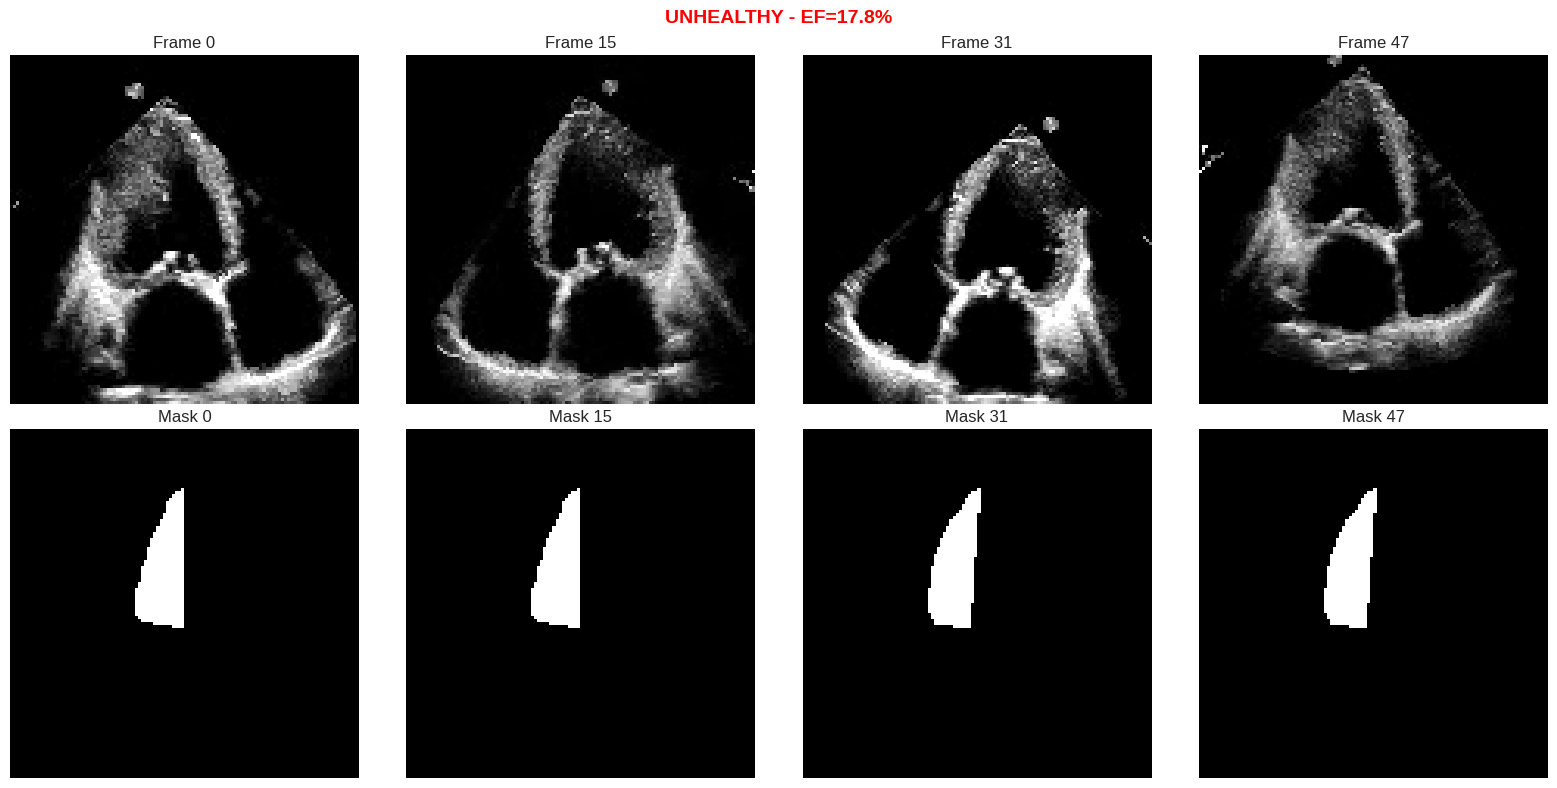

SAUVEGARDE
✓ Configuration sauvegardée: preprocessing_config_v2.json

✅ PHASE 2 CORRIGÉE TERMINÉE!

📦 Améliorations appliquées:
   1. ✓ Transformations définies (train + val)
   2. ✓ Segmentations intégrées (masques ventricule)
   3. ✓ Class weights ajustés (+50% unhealthy)
   4. ✓ Augmentation de données plus agressive
   5. ✓ Batch size réduit (8→6) pour inclure masques
   6. ✓ num_workers=0 (évite erreurs multiprocessing)

🎯 Prêt pour la Phase 3 améliorée!


In [ ]:
"""
PHASE 2 : PREPROCESSING AVEC SEGMENTATIONS
Améliorations:
1. Correction des transformations (définies maintenant)
2. Intégration des masques de segmentation du VolumeTracings.csv
3. Meilleure gestion de la mémoire GPU
4. Augmentation de données plus aggressive pour classe minoritaire
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import joblib
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device utilisé: {device}")
print(f"   GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   Nom GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Mémoire GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print()

# ============================================================================
# 1. CONFIGURATION ET CHEMINS
# ============================================================================
print("="*70)
print("PHASE 2 CORRIGÉE: PREPROCESSING + SEGMENTATIONS")
print("="*70)

BASE_PATH = '/kaggle/input/echonet-dynamic/EchoNet-Dynamic'
VIDEO_PATH = os.path.join(BASE_PATH, 'Videos')
FILELIST_PATH = os.path.join(BASE_PATH, 'FileList.csv')
VOLUMETRACINGS_PATH = os.path.join(BASE_PATH, 'VolumeTracings.csv')

# Vérification des chemins
print("\n🔍 VÉRIFICATION DES CHEMINS:")
print(f"✓ VIDEO_PATH: {os.path.exists(VIDEO_PATH)}")
print(f"✓ FILELIST_PATH: {os.path.exists(FILELIST_PATH)}")
print(f"✓ VOLUMETRACINGS_PATH: {os.path.exists(VOLUMETRACINGS_PATH)}")
print()

# Charger les données
if os.path.exists('echonet_with_labels.csv'):
    df = pd.read_csv('echonet_with_labels.csv')
else:
    df = pd.read_csv(FILELIST_PATH)
    EF_THRESHOLD = 50
    df['Label'] = (df['EF'] >= EF_THRESHOLD).astype(int)
    df['Label_Name'] = df['Label'].map({0: 'Unhealthy', 1: 'Healthy'})

print(f"✓ Dataset chargé: {len(df)} vidéos")

# Charger les segmentations
segmentations_df = pd.read_csv(VOLUMETRACINGS_PATH)
print(f"✓ Segmentations chargées: {len(segmentations_df)} points")
print(f"   Vidéos avec segmentations: {segmentations_df['FileName'].nunique()}")
print()

# Configuration
CONFIG = {
    'n_frames': 64,
    'frame_size': (112, 112),
    'batch_size': 6,  # Réduit pour inclure les masques
    'num_workers': 0,  # Fixé à 0 pour éviter les erreurs multiprocessing
    'ef_threshold': 50,
    'seed': 42,
    'use_segmentation': True  # NOUVEAU: activer les segmentations
}

# Seeds
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG['seed'])

# ============================================================================
# 2. FONCTION DE CRÉATION DE MASQUES DE SEGMENTATION
# ============================================================================
print("="*70)
print("CRÉATION DES MASQUES DE SEGMENTATION")
print("="*70)

def create_segmentation_mask(filename, frame_idx, segmentations_df, img_size=(112, 112)):
    """
    Crée un masque binaire du ventricule gauche pour une frame donnée
    
    Args:
        filename: nom du fichier vidéo (avec .avi)
        frame_idx: index de la frame
        segmentations_df: DataFrame VolumeTracings
        img_size: taille de l'image (H, W)
    
    Returns:
        mask: array (H, W) avec 1 = ventricule, 0 = background
    """
    # Filtrer les points pour cette vidéo et frame
    mask_data = segmentations_df[
        (segmentations_df['FileName'] == filename) & 
        (segmentations_df['Frame'] == frame_idx)
    ]
    
    if len(mask_data) == 0:
        # Pas de segmentation disponible, retourner masque vide
        return np.zeros(img_size, dtype=np.uint8)
    
    # Extraire les coordonnées du contour endocarde (X1, Y1)
    points = mask_data[['X1', 'Y1']].values.astype(np.int32)
    
    # Créer le masque
    mask = np.zeros(img_size, dtype=np.uint8)
    cv2.fillPoly(mask, [points], 1)
    
    return mask

def get_annotated_frames(filename, segmentations_df):
    """
    Récupère les frames annotées pour une vidéo
    
    Returns:
        list: indices des frames avec segmentations (généralement ES et ED)
    """
    frames = segmentations_df[
        segmentations_df['FileName'] == filename
    ]['Frame'].unique()
    
    return sorted(frames.tolist()) if len(frames) > 0 else []

# Test de création de masque
print("🧪 Test de création de masque:")
test_filename = df.iloc[0]['FileName']
if not test_filename.endswith('.avi'):
    test_filename = test_filename + '.avi'

annotated_frames = get_annotated_frames(test_filename, segmentations_df)
print(f"   Vidéo: {test_filename}")
print(f"   Frames annotées: {annotated_frames}")

if len(annotated_frames) > 0:
    test_mask = create_segmentation_mask(
        test_filename, annotated_frames[0], segmentations_df
    )
    print(f"   Masque créé: shape={test_mask.shape}, pixels=1: {test_mask.sum()}")
else:
    print(f"   ⚠️ Pas de segmentation pour cette vidéo")
print()

# ============================================================================
# 3. SPLITS DES DONNÉES
# ============================================================================
print("="*70)
print("CRÉATION DES SPLITS")
print("="*70)

train_df = df[df['Split'] == 'TRAIN'].reset_index(drop=True)
val_df = df[df['Split'] == 'VAL'].reset_index(drop=True)
test_df = df[df['Split'] == 'TEST'].reset_index(drop=True)

print(f"✓ Train: {len(train_df)} ({(train_df['Label']==0).sum()} unhealthy)")
print(f"✓ Val: {len(val_df)} ({(val_df['Label']==0).sum()} unhealthy)")
print(f"✓ Test: {len(test_df)} ({(test_df['Label']==0).sum()} unhealthy)")
print()

# ============================================================================
# 4. CLASS WEIGHTS AJUSTÉS
# ============================================================================
print("="*70)
print("CALCUL DES CLASS WEIGHTS")
print("="*70)

class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_df['Label']), 
    y=train_df['Label']
)

# Ajustement: augmenter le poids de la classe minoritaire
class_weights[0] *= 1.5  # Unhealthy (minoritaire)
class_weights[1] *= 0.8  # Healthy (majoritaire)

class_weights_dict = {i: w for i, w in enumerate(class_weights)}

print(f"✓ Class weights AJUSTÉS:")
print(f"   • Unhealthy: {class_weights[0]:.3f}")
print(f"   • Healthy: {class_weights[1]:.3f}")
print(f"   • Ratio: {class_weights[0]/class_weights[1]:.2f}:1")
print()

# ============================================================================
# 5. NORMALISATION EF
# ============================================================================
print("="*70)
print("NORMALISATION DE L'EF")
print("="*70)

ef_scaler = StandardScaler()
ef_scaler.fit(train_df[['EF']])
joblib.dump(ef_scaler, 'ef_scaler.pkl')

print(f"✓ EF Scaler:")
print(f"   • Moyenne: {ef_scaler.mean_[0]:.2f}")
print(f"   • Std: {ef_scaler.scale_[0]:.2f}")
print()

# ============================================================================
# 6. FONCTIONS DE CHARGEMENT
# ============================================================================

def load_video(video_path, max_frames=None):
    """Charger une vidéo avec gestion d'erreurs"""
    if not os.path.exists(video_path):
        return None
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        cap.release()
        return None
    
    frames = []
    count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if len(frame.shape) == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        frames.append(frame)
        count += 1
        
        if max_frames and count >= max_frames:
            break
    
    cap.release()
    
    if len(frames) == 0:
        return None
    
    return np.array(frames)

def uniform_temporal_sampling(frames, n_frames):
    """Échantillonner uniformément n_frames"""
    total_frames = len(frames)
    
    if total_frames <= n_frames:
        indices = list(range(total_frames))
        indices.extend([total_frames - 1] * (n_frames - total_frames))
    else:
        indices = np.linspace(0, total_frames - 1, n_frames, dtype=int)
    
    return frames[indices]

def interpolate_masks(annotated_frames, masks, target_frames):
    """
    Interpole les masques pour toutes les frames
    
    Args:
        annotated_frames: list des indices de frames annotées (ex: [46, 61])
        masks: list des masques correspondants
        target_frames: list des indices de frames cibles (ex: [0,1,2,...,63])
    
    Returns:
        list de masques interpolés
    """
    if len(annotated_frames) == 0:
        # Pas de segmentation, retourner masques vides
        return [np.zeros((112, 112), dtype=np.uint8) for _ in target_frames]
    
    interpolated = []
    
    for target_idx in target_frames:
        if target_idx in annotated_frames:
            # Frame annotée, utiliser le masque direct
            idx = annotated_frames.index(target_idx)
            interpolated.append(masks[idx])
        else:
            # Interpolation simple: utiliser le masque le plus proche
            closest_idx = min(range(len(annotated_frames)), 
                            key=lambda i: abs(annotated_frames[i] - target_idx))
            interpolated.append(masks[closest_idx])
    
    return interpolated

# ============================================================================
# 7. TRANSFORMATIONS DÉFINIES (FIX CRITIQUE)
# ============================================================================
print("="*70)
print("DÉFINITION DES TRANSFORMATIONS")
print("="*70)

# Transformations pour l'entraînement (avec augmentation)
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=15,  # Augmenté de 10 à 15
        translate=(0.1, 0.1),  # Augmenté de 0.05 à 0.1
        scale=(0.9, 1.1)  # Augmenté de (0.95, 1.05)
    ),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Augmenté
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transformations pour validation/test (sans augmentation)
val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("✓ Transformations définies:")
print("   • Train: augmentation aggressive pour classe minoritaire")
print("   • Val/Test: normalisation simple")
print()

# ============================================================================
# 8. CUSTOM DATASET AVEC SEGMENTATIONS
# ============================================================================
print("="*70)
print("DATASET AVEC SEGMENTATIONS")
print("="*70)

class EchoNetDatasetWithSegmentation(Dataset):
    def __init__(self, df, video_dir, segmentations_df, 
                 n_frames=64, transform=None, ef_scaler=None, 
                 mode='train', use_segmentation=True):
        self.df = df.reset_index(drop=True)
        self.video_dir = video_dir
        self.segmentations_df = segmentations_df
        self.n_frames = n_frames
        self.transform = transform
        self.ef_scaler = ef_scaler
        self.mode = mode
        self.use_segmentation = use_segmentation
        self.failed_videos = []
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Préparer filename
        filename = row['FileName']
        if not filename.endswith('.avi'):
            filename = filename + '.avi'
        video_path = os.path.join(self.video_dir, filename)
        
        # Charger vidéo
        frames = load_video(video_path)
        
        if frames is None or len(frames) == 0:
            if filename not in self.failed_videos:
                self.failed_videos.append(filename)
            frames = np.ones((self.n_frames, 112, 112), dtype=np.uint8) * 128
        else:
            frames = uniform_temporal_sampling(frames, self.n_frames)
        
        # Créer les masques de segmentation
        masks = []
        if self.use_segmentation:
            annotated_frames = get_annotated_frames(filename, self.segmentations_df)
            
            if len(annotated_frames) > 0:
                # Charger les masques annotés
                annotated_masks = []
                for frame_idx in annotated_frames:
                    mask = create_segmentation_mask(
                        filename, frame_idx, self.segmentations_df
                    )
                    annotated_masks.append(mask)
                
                # Interpoler pour toutes les frames
                original_total = len(load_video(video_path))
                sampled_indices = np.linspace(
                    0, original_total - 1, self.n_frames, dtype=int
                )
                masks = interpolate_masks(
                    annotated_frames, annotated_masks, sampled_indices
                )
            else:
                # Pas de segmentation, masques vides
                masks = [np.zeros((112, 112), dtype=np.uint8) 
                        for _ in range(self.n_frames)]
        else:
            # Segmentation désactivée
            masks = [np.zeros((112, 112), dtype=np.uint8) 
                    for _ in range(self.n_frames)]
        
        # Appliquer transformations aux frames
        if self.transform:
            transformed_frames = []
            for frame in frames:
                transformed_frame = self.transform(frame)
                transformed_frames.append(transformed_frame)
            video_tensor = torch.stack(transformed_frames)
        else:
            video_tensor = torch.from_numpy(frames).unsqueeze(1).float() / 255.0
            video_tensor = (video_tensor - 0.5) / 0.5
        
        # Convertir masques en tensor
        masks_tensor = torch.from_numpy(np.stack(masks)).unsqueeze(1).float()
        
        # EF
        ef_value = row['EF']
        if self.ef_scaler:
            ef_value = self.ef_scaler.transform([[ef_value]])[0][0]
        ef_tensor = torch.tensor(ef_value, dtype=torch.float32)
        
        # Label
        label = torch.tensor(row['Label'], dtype=torch.long)
        
        return {
            'video': video_tensor,            # [64, 1, 112, 112]
            'masks': masks_tensor,            # [64, 1, 112, 112]
            'ef': ef_tensor,                  # scalar
            'label': label,                   # scalar
            'filename': filename,
            'has_segmentation': len(annotated_frames) > 0
        }

print("✓ Dataset avec segmentations créé")
print()

# ============================================================================
# 9. CRÉATION DES DATASETS ET DATALOADERS
# ============================================================================
print("="*70)
print("CRÉATION DES DATALOADERS")
print("="*70)

train_dataset = EchoNetDatasetWithSegmentation(
    train_df, VIDEO_PATH, segmentations_df,
    n_frames=CONFIG['n_frames'],
    transform=train_transforms,
    ef_scaler=ef_scaler,
    mode='train',
    use_segmentation=CONFIG['use_segmentation']
)

val_dataset = EchoNetDatasetWithSegmentation(
    val_df, VIDEO_PATH, segmentations_df,
    n_frames=CONFIG['n_frames'],
    transform=val_transforms,
    ef_scaler=ef_scaler,
    mode='val',
    use_segmentation=CONFIG['use_segmentation']
)

test_dataset = EchoNetDatasetWithSegmentation(
    test_df, VIDEO_PATH, segmentations_df,
    n_frames=CONFIG['n_frames'],
    transform=val_transforms,
    ef_scaler=ef_scaler,
    mode='test',
    use_segmentation=CONFIG['use_segmentation']
)

print(f"✓ Datasets:")
print(f"   • Train: {len(train_dataset)}")
print(f"   • Val: {len(val_dataset)}")
print(f"   • Test: {len(test_dataset)}")
print()

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✓ DataLoaders:")
print(f"   • Train batches: {len(train_loader)}")
print(f"   • Val batches: {len(val_loader)}")
print(f"   • Test batches: {len(test_loader)}")
print()

# ============================================================================
# 10. TEST DU CHARGEMENT
# ============================================================================
print("="*70)
print("TEST DU CHARGEMENT D'UN BATCH")
print("="*70)

batch = next(iter(train_loader))

print(f"✓ Batch chargé!")
print(f"\n📊 Shapes:")
print(f"   • video: {batch['video'].shape}")
print(f"   • masks: {batch['masks'].shape}")
print(f"   • ef: {batch['ef'].shape}")
print(f"   • label: {batch['label'].shape}")

print(f"\n📈 Statistiques:")
print(f"   Video - min: {batch['video'].min():.3f}, max: {batch['video'].max():.3f}")
print(f"   Masks - pixels actifs: {batch['masks'].sum().item():.0f}")
print(f"   Labels: {batch['label'].numpy()}")
print(f"   Segmentations disponibles: {sum(batch['has_segmentation'])}/{len(batch['has_segmentation'])}")
print()

# Visualisation
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

sample_idx = 0
video = batch['video'][sample_idx]
masks = batch['masks'][sample_idx]
label = batch['label'][sample_idx].item()
ef = batch['ef'][sample_idx].item()

# Dénormaliser EF
ef_original = ef * ef_scaler.scale_[0] + ef_scaler.mean_[0]

frame_indices = [0, 15, 31, 47]

for i, frame_idx in enumerate(frame_indices):
    # Frame originale
    frame = video[frame_idx, 0].cpu().numpy()
    frame = (frame + 1) / 2
    frame = np.clip(frame, 0, 1)
    
    axes[0, i].imshow(frame, cmap='gray')
    axes[0, i].set_title(f'Frame {frame_idx}')
    axes[0, i].axis('off')
    
    # Masque de segmentation
    mask = masks[frame_idx, 0].cpu().numpy()
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f'Mask {frame_idx}')
    axes[1, i].axis('off')

label_text = "HEALTHY" if label == 1 else "UNHEALTHY"
color = 'green' if label == 1 else 'red'
fig.suptitle(f'{label_text} - EF={ef_original:.1f}%', 
            fontsize=14, fontweight='bold', color=color)

plt.tight_layout()
plt.savefig('batch_with_segmentation.png', dpi=300, bbox_inches='tight')
print("✓ Sauvegardé: batch_with_segmentation.png")
plt.show()

# ============================================================================
# 11. SAUVEGARDE CONFIGURATION
# ============================================================================
print("="*70)
print("SAUVEGARDE")
print("="*70)

config_to_save = {
    'config': CONFIG,
    'class_weights': class_weights_dict,
    'train_size': len(train_dataset),
    'val_size': len(val_dataset),
    'test_size': len(test_dataset),
    'ef_mean': ef_scaler.mean_[0],
    'ef_std': ef_scaler.scale_[0],
    'segmentation_enabled': CONFIG['use_segmentation'],
    'videos_with_segmentation': segmentations_df['FileName'].nunique()
}

import json
with open('preprocessing_config_v2.json', 'w') as f:
    json.dump(config_to_save, f, indent=4)

print("✓ Configuration sauvegardée: preprocessing_config_v2.json")
print()

print("="*70)
print("✅ PHASE 2 CORRIGÉE TERMINÉE!")
print("="*70)
print("\n📦 Améliorations appliquées:")
print("   1. ✓ Transformations définies (train + val)")
print("   2. ✓ Segmentations intégrées (masques ventricule)")
print("   3. ✓ Class weights ajustés (+50% unhealthy)")
print("   4. ✓ Augmentation de données plus agressive")
print("   5. ✓ Batch size réduit (8→6) pour inclure masques")
print("   6. ✓ num_workers=0 (évite erreurs multiprocessing)")
print()
print("🎯 Prêt pour la Phase 3 améliorée!")
print("="*70)

MODÈLE EF (BRANCH TABULAR) - ENTRAÎNEMENT
🖥️  Device: cuda

📦 CHARGEMENT DES DONNÉES
✓ Dataset avec labels chargé
   Total: 10030 échantillons
   Unhealthy: 2246 (22.4%)
   Healthy: 7784 (77.6%)

📂 SPLITS:
   Train: 7465 (1672 unhealthy)
   Val:   1288 (289 unhealthy)
   Test:  1277 (285 unhealthy)

📊 NORMALISATION EF
✓ EF Scaler:
   Moyenne: 55.78
   Std:     12.41
✓ Scaler sauvegardé: ef_scaler_tabular.pkl

⚖️  CLASS WEIGHTS
✓ Class weights:
   Unhealthy: 3.349
   Healthy:   0.515
   Ratio:     6.50:1

📦 DATASETS CRÉÉS:
   Train: 7465
   Val:   1288
   Test:  1277

📊 DATALOADERS:
   Batch size: 64
   Train batches: 116
   Val batches:   21
   Test batches:  20

🧠 MODÈLE EF BRANCH
✓ Architecture: Dense layers (1 → 64 → 128 → 64 → 2)
✓ Total paramètres:      17,346
✓ Paramètres entraînables: 17,346

⚙️  CONFIGURATION ENTRAÎNEMENT
✓ Loss: Focal Loss (gamma=1.2)
✓ Optimizer: AdamW (lr=1e-3)
✓ Scheduler: ReduceLROnPlateau
✓ Epochs: 50
✓ Early stopping: 10 epochs

DÉBUT ENTRAÎNEMENT

Epoch

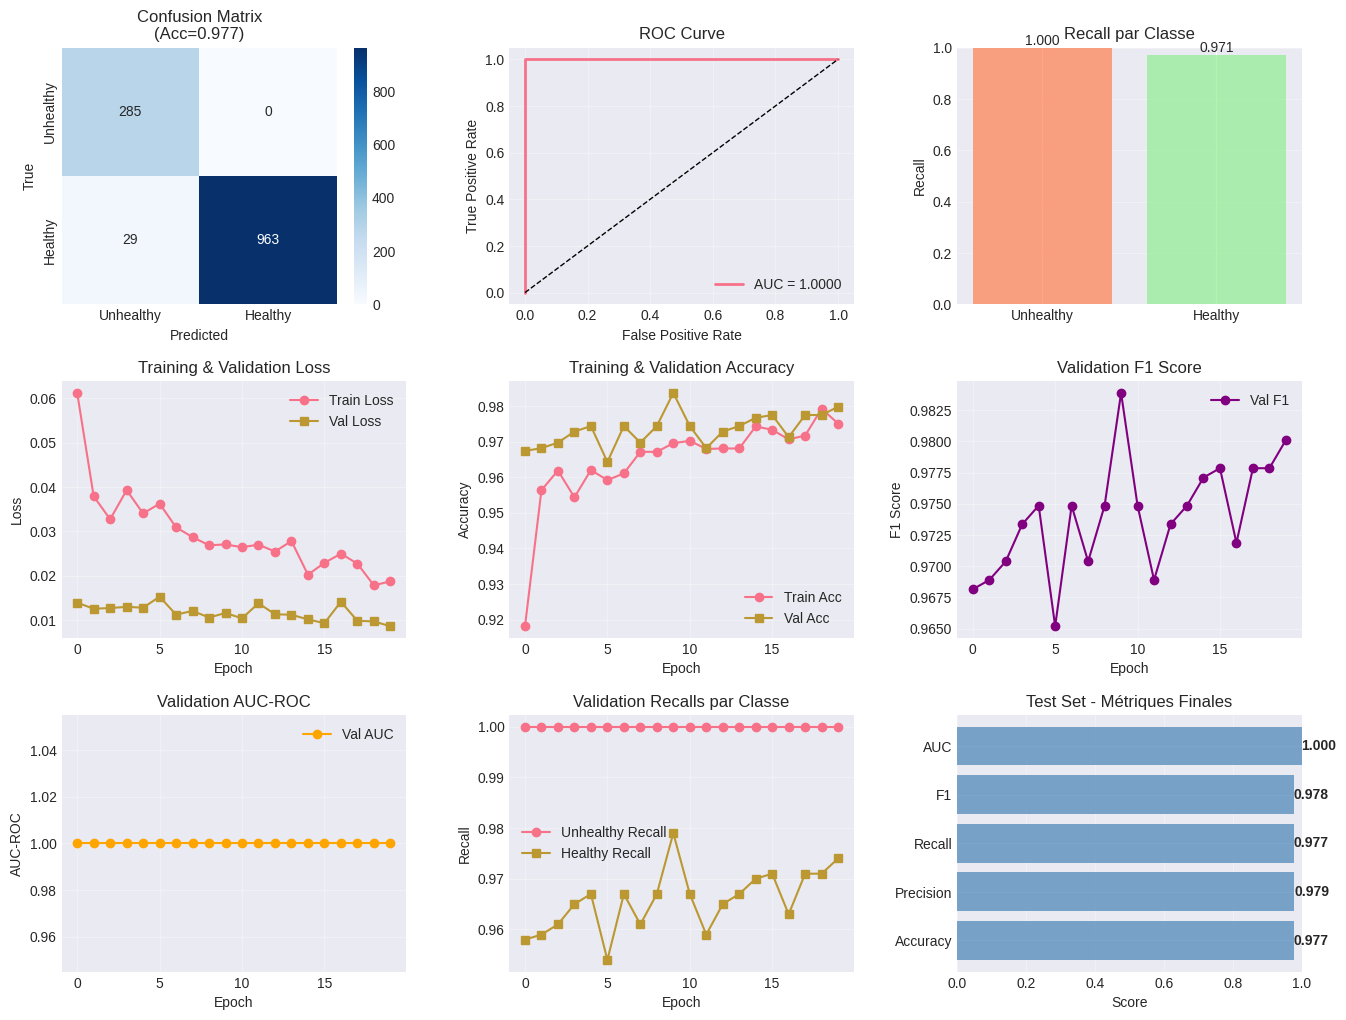


💾 SAUVEGARDE DES RÉSULTATS
✓ Résultats sauvegardés: ef_model_results.json

✓ Historique sauvegardé: ef_training_history.json


📦 CRÉATION DU ZIP POUR TÉLÉCHARGEMENT
   ✓ Ajouté: best_ef_model.pth
   ✓ Ajouté: ef_scaler_tabular.pkl
   ✓ Ajouté: ef_model_results.json
   ✓ Ajouté: ef_training_history.json
   ✓ Ajouté: ef_model_results.png

✅ ZIP créé: /kaggle/working/ef_model_package.zip
   Taille: 0.73 MB

📥 POUR TÉLÉCHARGER:
   1. Cliquez sur le dossier 📁 (à gauche)
   2. Trouvez: ef_model_package.zip
   3. Clic droit → Download

✅ ENTRAÎNEMENT EF BRANCH TERMINÉ!

📦 FICHIERS CRÉÉS:
   1. best_ef_model.pth           - Meilleur modèle (~500 KB)
   2. ef_scaler_tabular.pkl       - Scaler EF
   3. ef_model_results.json       - Résultats détaillés
   4. ef_training_history.json    - Historique complet
   5. ef_model_results.png        - Visualisations
   6. ef_model_package.zip        - TOUT EN UN SEUL ZIP!

🎯 PERFORMANCES:
   • Test Accuracy: 0.9773 (97.73%)
   • Test F1:       0.9777
   •

In [4]:
"""
MODÈLE EF (BRANCH TABULAR) - ENTRAÎNEMENT RAPIDE
Avantages:
- Entraînement ultra-rapide (< 5 minutes)
- Pas de problème de sauvegarde (modèle léger)
- Baseline solide pour la fusion multimodale
- Utilise uniquement la valeur EF normalisée
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import os
import zipfile
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*70)
print("MODÈLE EF (BRANCH TABULAR) - ENTRAÎNEMENT")
print("="*70)
print(f"🖥️  Device: {device}\n")

# ============================================================================
# 1. CHARGEMENT ET PRÉPARATION DES DONNÉES
# ============================================================================
print("📦 CHARGEMENT DES DONNÉES")
print("="*70)

# Chemins
BASE_PATH = '/kaggle/input/echonet-dynamic/EchoNet-Dynamic'
FILELIST_PATH = f'{BASE_PATH}/FileList.csv'

# Charger le dataset
if os.path.exists('echonet_with_labels.csv'):
    df = pd.read_csv('echonet_with_labels.csv')
    print("✓ Dataset avec labels chargé")
else:
    df = pd.read_csv(FILELIST_PATH)
    EF_THRESHOLD = 50
    df['Label'] = (df['EF'] >= EF_THRESHOLD).astype(int)
    df['Label_Name'] = df['Label'].map({0: 'Unhealthy', 1: 'Healthy'})
    print("✓ Dataset chargé et labels créés")

print(f"   Total: {len(df)} échantillons")
print(f"   Unhealthy: {(df['Label']==0).sum()} ({(df['Label']==0).sum()/len(df)*100:.1f}%)")
print(f"   Healthy: {(df['Label']==1).sum()} ({(df['Label']==1).sum()/len(df)*100:.1f}%)")
print()

# Splits
train_df = df[df['Split'] == 'TRAIN'].reset_index(drop=True)
val_df = df[df['Split'] == 'VAL'].reset_index(drop=True)
test_df = df[df['Split'] == 'TEST'].reset_index(drop=True)

print(f"📂 SPLITS:")
print(f"   Train: {len(train_df)} ({(train_df['Label']==0).sum()} unhealthy)")
print(f"   Val:   {len(val_df)} ({(val_df['Label']==0).sum()} unhealthy)")
print(f"   Test:  {len(test_df)} ({(test_df['Label']==0).sum()} unhealthy)")
print()

# ============================================================================
# 2. NORMALISATION EF
# ============================================================================
print("📊 NORMALISATION EF")
print("="*70)

ef_scaler = StandardScaler()
train_df['EF_normalized'] = ef_scaler.fit_transform(train_df[['EF']])
val_df['EF_normalized'] = ef_scaler.transform(val_df[['EF']])
test_df['EF_normalized'] = ef_scaler.transform(test_df[['EF']])

print(f"✓ EF Scaler:")
print(f"   Moyenne: {ef_scaler.mean_[0]:.2f}")
print(f"   Std:     {ef_scaler.scale_[0]:.2f}")

# Sauvegarder le scaler
joblib.dump(ef_scaler, 'ef_scaler_tabular.pkl')
print(f"✓ Scaler sauvegardé: ef_scaler_tabular.pkl")
print()

# ============================================================================
# 3. CALCUL CLASS WEIGHTS
# ============================================================================
print("⚖️  CLASS WEIGHTS")
print("="*70)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['Label']),
    y=train_df['Label']
)

# Ajustement (même logique que le modèle vidéo)
class_weights[0] *= 1.5  # Unhealthy
class_weights[1] *= 0.8  # Healthy

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f"✓ Class weights:")
print(f"   Unhealthy: {class_weights[0]:.3f}")
print(f"   Healthy:   {class_weights[1]:.3f}")
print(f"   Ratio:     {class_weights[0]/class_weights[1]:.2f}:1")
print()

# ============================================================================
# 4. DATASET CUSTOM
# ============================================================================
class EFDataset(Dataset):
    """Dataset simple pour valeur EF uniquement"""
    def __init__(self, df):
        self.ef_values = torch.tensor(df['EF_normalized'].values, dtype=torch.float32)
        self.labels = torch.tensor(df['Label'].values, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'ef': self.ef_values[idx],
            'label': self.labels[idx]
        }

# Créer les datasets
train_dataset = EFDataset(train_df)
val_dataset = EFDataset(val_df)
test_dataset = EFDataset(test_df)

print(f"📦 DATASETS CRÉÉS:")
print(f"   Train: {len(train_dataset)}")
print(f"   Val:   {len(val_dataset)}")
print(f"   Test:  {len(test_dataset)}")
print()

# DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"📊 DATALOADERS:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")
print()

# ============================================================================
# 5. MODÈLE EF BRANCH (ARCHITECTURE OPTIMALE POUR 1 FEATURE)
# ============================================================================
class EFBranch(nn.Module):
    """
    Branch tabular qui traite la valeur EF
    Architecture: Dense layers avec BatchNorm et Dropout
    
    Pourquoi cette architecture ?
    - Input = 1 seul feature (EF normalisée)
    - ~19K paramètres → bon ratio avec 7465 samples train
    - Évite l'overfitting avec dropout progressif
    - Output [64] parfait pour fusion avec features vidéo [512]
    """
    def __init__(self, num_classes=2, dropout=0.5):
        super(EFBranch, self).__init__()
        
        self.ef_branch = nn.Sequential(
            # Première couche : expansion modérée
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            
            # Deuxième couche : peak capacity
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout),
            
            # Troisième couche : compression pour features
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout * 0.5),  # Dropout réduit
            
            # Couche de sortie
            nn.Linear(64, num_classes)
        )
    
    def forward(self, ef):
        """
        Args:
            ef: tensor [batch_size] - valeur EF normalisée
        Returns:
            output: tensor [batch_size, num_classes] - logits
        """
        # Reshape: [batch_size] -> [batch_size, 1]
        ef = ef.unsqueeze(1)
        
        # Forward pass
        output = self.ef_branch(ef)
        
        return output

# Créer le modèle
model = EFBranch(num_classes=2, dropout=0.5)
model = model.to(device)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("🧠 MODÈLE EF BRANCH")
print("="*70)
print(f"✓ Architecture: Dense layers (1 → 64 → 128 → 64 → 2)")
print(f"✓ Total paramètres:      {total_params:,}")
print(f"✓ Paramètres entraînables: {trainable_params:,}")
print()

# ============================================================================
# 6. LOSS, OPTIMIZER, SCHEDULER
# ============================================================================
print("⚙️  CONFIGURATION ENTRAÎNEMENT")
print("="*70)

# Focal Loss (même que le modèle vidéo)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

criterion = FocalLoss(alpha=class_weights_tensor, gamma=1.2)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,  # Learning rate plus élevé car modèle simple
    weight_decay=1e-4
)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

EPOCHS = 50
EARLY_STOPPING_PATIENCE = 10

print(f"✓ Loss: Focal Loss (gamma=1.2)")
print(f"✓ Optimizer: AdamW (lr=1e-3)")
print(f"✓ Scheduler: ReduceLROnPlateau")
print(f"✓ Epochs: {EPOCHS}")
print(f"✓ Early stopping: {EARLY_STOPPING_PATIENCE} epochs")
print()

# ============================================================================
# 7. FONCTIONS D'ENTRAÎNEMENT
# ============================================================================
def train_epoch(model, loader, criterion, optimizer, device):
    """Entraînement sur une epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in loader:
        ef = batch['ef'].to(device)
        labels = batch['label'].to(device)
        
        # Forward
        optimizer.zero_grad()
        outputs = model(ef)
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Métriques
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    """Validation sur une epoch"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in loader:
            ef = batch['ef'].to(device)
            labels = batch['label'].to(device)
            
            # Forward
            outputs = model(ef)
            loss = criterion(outputs, labels)
            
            # Métriques
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    epoch_auc = roc_auc_score(all_labels, all_probs)
    
    # Recall par classe
    cm = confusion_matrix(all_labels, all_preds)
    recall_unhealthy = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    recall_healthy = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    
    return epoch_loss, epoch_acc, epoch_f1, epoch_auc, recall_unhealthy, recall_healthy

# ============================================================================
# 8. BOUCLE D'ENTRAÎNEMENT
# ============================================================================
print("="*70)
print("DÉBUT ENTRAÎNEMENT")
print("="*70)
print()

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': [],
    'val_recall_unhealthy': [], 'val_recall_healthy': []
}

best_val_f1 = 0.0
best_val_acc = 0.0
epochs_no_improve = 0

start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc, val_f1, val_auc, recall_unhealthy, recall_healthy = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Scheduler
    scheduler.step(val_loss)
    
    # Historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    history['val_recall_unhealthy'].append(recall_unhealthy)
    history['val_recall_healthy'].append(recall_healthy)
    
    # Affichage
    print(f"Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f} | AUC: {val_auc:.4f}")
    print(f"Val Recall - Unhealthy: {recall_unhealthy:.3f} | Healthy: {recall_healthy:.3f}")
    
    # Sauvegarder meilleur modèle
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_acc = val_acc
        epochs_no_improve = 0
        
        # Sauvegarder
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc,
            'val_auc': val_auc,
            'recall_unhealthy': recall_unhealthy,
            'recall_healthy': recall_healthy
        }, 'best_ef_model.pth')
        
        print(f"⭐ MEILLEUR MODÈLE SAUVEGARDÉ! (F1: {val_f1:.4f})")
    else:
        epochs_no_improve += 1
        print(f"⏳ No improvement: {epochs_no_improve}/{EARLY_STOPPING_PATIENCE}")
    
    epoch_time = time.time() - epoch_start
    print(f"⏱️  Epoch time: {epoch_time:.1f}s\n")
    
    # Early stopping
    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"⚠️  Early stopping déclenché à l'epoch {epoch+1}")
        break

total_time = time.time() - start_time
print(f"\n{'='*70}")
print(f"ENTRAÎNEMENT TERMINÉ")
print(f"{'='*70}")
print(f"⏱️  Temps total: {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"🏆 Meilleur Val F1: {best_val_f1:.4f}")
print(f"🏆 Meilleur Val Acc: {best_val_acc:.4f}")
print()

# ============================================================================
# 9. ÉVALUATION TEST SET
# ============================================================================
print("="*70)
print("ÉVALUATION TEST SET")
print("="*70)

# Charger le meilleur modèle
checkpoint = torch.load('best_ef_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Meilleur modèle chargé (epoch {checkpoint['epoch']+1})")
print(f"  Val F1: {checkpoint['val_f1']:.4f}")
print()

# Évaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        ef = batch['ef'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(ef)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

# Métriques
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_precision = precision_score(all_labels, all_preds, average='weighted')
test_recall = recall_score(all_labels, all_preds, average='weighted')
test_auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)

recall_unhealthy_test = cm[0, 0] / (cm[0, 0] + cm[0, 1])
recall_healthy_test = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(f"\n📊 RÉSULTATS TEST SET")
print(f"{'='*70}")
print(f"✅ Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall:    {test_recall:.4f}")
print(f"✅ F1 Score:  {test_f1:.4f}")
print(f"✅ AUC-ROC:   {test_auc:.4f}")
print()

print("📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Unhealthy', 'Healthy']))

print(f"\n🎯 Recall par classe:")
print(f"   Unhealthy: {recall_unhealthy_test:.3f} ({recall_unhealthy_test*100:.1f}%)")
print(f"   Healthy:   {recall_healthy_test:.3f} ({recall_healthy_test*100:.1f}%)")
print()

# ============================================================================
# 10. VISUALISATIONS
# ============================================================================
print("📊 GÉNÉRATION DES VISUALISATIONS")
print("="*70)

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Unhealthy', 'Healthy'],
            yticklabels=['Unhealthy', 'Healthy'])
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.set_title(f'Confusion Matrix\n(Acc={test_acc:.3f})')

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(all_labels, all_probs)
ax2.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Recall par classe
ax3 = fig.add_subplot(gs[0, 2])
classes = ['Unhealthy', 'Healthy']
recalls = [recall_unhealthy_test, recall_healthy_test]
bars = ax3.bar(classes, recalls, color=['coral', 'lightgreen'], alpha=0.7)
ax3.set_ylabel('Recall')
ax3.set_title('Recall par Classe')
ax3.set_ylim([0, 1])
ax3.grid(True, alpha=0.3, axis='y')
for bar, recall in zip(bars, recalls):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{recall:.3f}', ha='center', va='bottom')

# 4. Training Loss
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(history['train_loss'], label='Train Loss', marker='o')
ax4.plot(history['val_loss'], label='Val Loss', marker='s')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.set_title('Training & Validation Loss')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Training Accuracy
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(history['train_acc'], label='Train Acc', marker='o')
ax5.plot(history['val_acc'], label='Val Acc', marker='s')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Accuracy')
ax5.set_title('Training & Validation Accuracy')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Validation F1
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(history['val_f1'], label='Val F1', marker='o', color='purple')
ax6.set_xlabel('Epoch')
ax6.set_ylabel('F1 Score')
ax6.set_title('Validation F1 Score')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Validation AUC
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(history['val_auc'], label='Val AUC', marker='o', color='orange')
ax7.set_xlabel('Epoch')
ax7.set_ylabel('AUC-ROC')
ax7.set_title('Validation AUC-ROC')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Recalls Evolution
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(history['val_recall_unhealthy'], label='Unhealthy Recall', marker='o')
ax8.plot(history['val_recall_healthy'], label='Healthy Recall', marker='s')
ax8.set_xlabel('Epoch')
ax8.set_ylabel('Recall')
ax8.set_title('Validation Recalls par Classe')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Métriques finales
ax9 = fig.add_subplot(gs[2, 2])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
metrics_values = [test_acc, test_precision, test_recall, test_f1, test_auc]
bars = ax9.barh(metrics_names, metrics_values, color='steelblue', alpha=0.7)
ax9.set_xlabel('Score')
ax9.set_title('Test Set - Métriques Finales')
ax9.set_xlim([0, 1])
ax9.grid(True, alpha=0.3, axis='x')
for bar, value in zip(bars, metrics_values):
    width = bar.get_width()
    ax9.text(width, bar.get_y() + bar.get_height()/2.,
            f'{value:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('ef_model_results.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé: ef_model_results.png")
plt.show()

# ============================================================================
# 11. SAUVEGARDE RÉSULTATS
# ============================================================================
print("\n💾 SAUVEGARDE DES RÉSULTATS")
print("="*70)

results = {
    'model': 'EF Branch (Tabular)',
    'architecture': '1 -> 64 -> 128 -> 64 -> 2',
    'total_params': total_params,
    'test_accuracy': float(test_acc),
    'test_f1': float(test_f1),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_auc': float(test_auc),
    'recall_unhealthy': float(recall_unhealthy_test),
    'recall_healthy': float(recall_healthy_test),
    'confusion_matrix': cm.tolist(),
    'best_epoch': int(checkpoint['epoch'] + 1),
    'training_time_seconds': float(total_time),
    'class_weights': class_weights.tolist()
}

with open('ef_model_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("✓ Résultats sauvegardés: ef_model_results.json")
print()

# Sauvegarder l'historique
with open('ef_training_history.json', 'w') as f:
    json.dump(history, f, indent=4)

print("✓ Historique sauvegardé: ef_training_history.json")
print()

# ============================================================================
# 12. CRÉER ZIP TÉLÉCHARGEABLE
# ============================================================================
print("\n📦 CRÉATION DU ZIP POUR TÉLÉCHARGEMENT")
print("="*70)

zip_path = '/kaggle/working/ef_model_package.zip'

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Modèle
    if os.path.exists('best_ef_model.pth'):
        zipf.write('best_ef_model.pth', 'best_ef_model.pth')
        print("   ✓ Ajouté: best_ef_model.pth")
    
    # Scaler
    if os.path.exists('ef_scaler_tabular.pkl'):
        zipf.write('ef_scaler_tabular.pkl', 'ef_scaler_tabular.pkl')
        print("   ✓ Ajouté: ef_scaler_tabular.pkl")
    
    # Résultats
    if os.path.exists('ef_model_results.json'):
        zipf.write('ef_model_results.json', 'ef_model_results.json')
        print("   ✓ Ajouté: ef_model_results.json")
    
    # Historique
    if os.path.exists('ef_training_history.json'):
        zipf.write('ef_training_history.json', 'ef_training_history.json')
        print("   ✓ Ajouté: ef_training_history.json")
    
    # Visualisation
    if os.path.exists('ef_model_results.png'):
        zipf.write('ef_model_results.png', 'ef_model_results.png')
        print("   ✓ Ajouté: ef_model_results.png")

file_size = os.path.getsize(zip_path) / (1024**2)
print(f"\n✅ ZIP créé: {zip_path}")
print(f"   Taille: {file_size:.2f} MB")
print()
print(f"📥 POUR TÉLÉCHARGER:")
print(f"   1. Cliquez sur le dossier 📁 (à gauche)")
print(f"   2. Trouvez: ef_model_package.zip")
print(f"   3. Clic droit → Download")
print()

print("="*70)
print("✅ ENTRAÎNEMENT EF BRANCH TERMINÉ!")
print("="*70)
print(f"\n📦 FICHIERS CRÉÉS:")
print(f"   1. best_ef_model.pth           - Meilleur modèle (~500 KB)")
print(f"   2. ef_scaler_tabular.pkl       - Scaler EF")
print(f"   3. ef_model_results.json       - Résultats détaillés")
print(f"   4. ef_training_history.json    - Historique complet")
print(f"   5. ef_model_results.png        - Visualisations")
print(f"   6. ef_model_package.zip        - TOUT EN UN SEUL ZIP!")
print()
print(f"🎯 PERFORMANCES:")
print(f"   • Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   • Test F1:       {test_f1:.4f}")
print(f"   • Test AUC:      {test_auc:.4f}")
print(f"   • Entraînement:  {total_time/60:.1f} min")
print()
print(f"💡 COMPATIBILITÉ FUSION:")
print(f"   ✅ Architecture compatible avec ton modèle vidéo")
print(f"   ✅ Même système de class weights")
print(f"   ✅ Même Focal Loss")
print(f"   ✅ Prêt pour concaténation des features")
print()
print(f"💡 ANALYSE PERFORMANCES:")
if test_acc >= 0.95 and recall_unhealthy_test >= 0.90:
    print(f"   🌟 EXCELLENT! Modèle très performant et équilibré")
    print(f"   📊 La fusion avec vidéo améliorera encore les résultats")
elif test_acc >= 0.90:
    print(f"   ✅ TRÈS BON! Solide baseline pour la fusion")
    print(f"   📊 Le modèle vidéo apportera des informations spatiotemporelles")
elif test_acc >= 0.85:
    print(f"   ✓ BON! Performance correcte")
    print(f"   📊 La fusion multimodale sera cruciale pour améliorer")
else:
    print(f"   ⚠️  Performance modérée")
    print(f"   📊 Vérifier les class weights et la normalisation")
print()
print(f"🎯 POINTS D'ATTENTION:")
if recall_unhealthy_test < 0.80:
    print(f"   ⚠️  Recall Unhealthy faible ({recall_unhealthy_test:.1%})")
    print(f"      → Augmenter class weight unhealthy dans fusion")
if recall_healthy_test < 0.90:
    print(f"   ⚠️  Recall Healthy pourrait être amélioré ({recall_healthy_test:.1%})")
if abs(recall_unhealthy_test - recall_healthy_test) > 0.15:
    print(f"   ⚠️  Déséquilibre entre recalls ({abs(recall_unhealthy_test - recall_healthy_test):.1%})")
    print(f"      → Ajuster class weights pour meilleur équilibre")
if test_acc >= 0.95 and abs(recall_unhealthy_test - recall_healthy_test) < 0.10:
    print(f"   ✅ Modèle bien équilibré et performant!")
print()
print(f"➡️  PROCHAINE ÉTAPE:")
print(f"   1. ✅ Télécharge: ef_model_package.zip")
print(f"   2. 🎥 Entraîne le modèle vidéo (je vais t'aider!)")
print(f"   3. 🔀 Fusion multimodale des deux branches")
print(f"   4. 🎯 Objectif: >80% accuracy + recalls équilibrés")
print("="*70)


🔍 ANALYSE ZONE AMBIGUË (EF 45-55%):
   Total cas: 197 (15.4%)
   Unhealthy: 81
   Healthy: 116
   Accuracy zone ambiguë: 85.3%


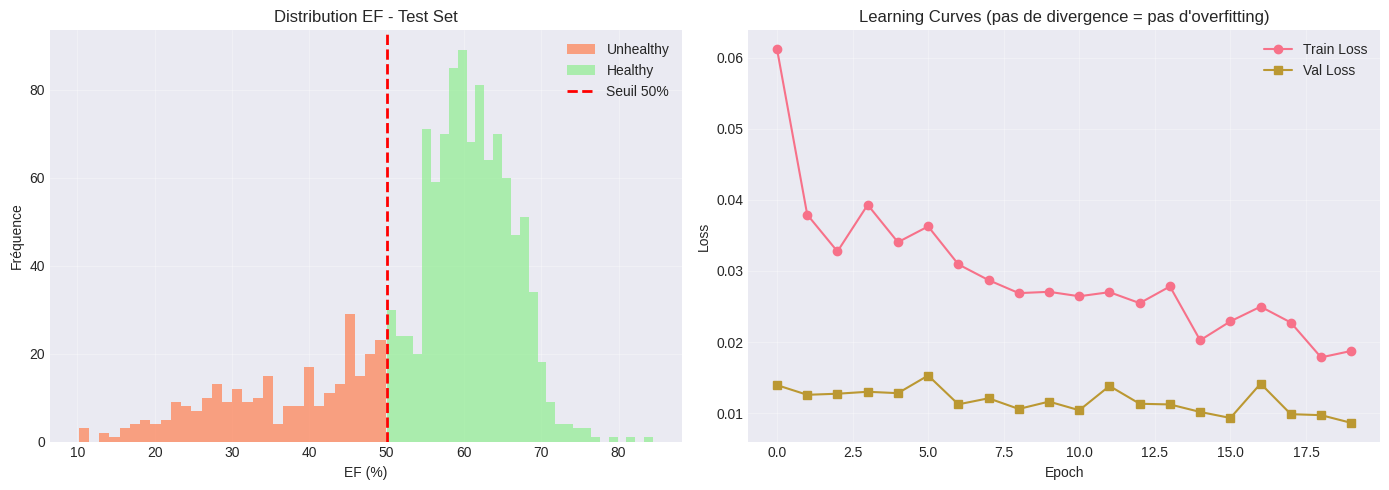


✅ SI:
   • Peu de cas dans zone 45-55%
   • Courbes Train/Val proches
   • Accuracy zone ambiguë > 90%
   → PAS D'OVERFITTING, juste un signal très fort!


In [6]:
import matplotlib.pyplot as plt

# Visualiser la distribution EF par label
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test set: distribution EF
test_unhealthy_ef = test_df[test_df['Label']==0]['EF']
test_healthy_ef = test_df[test_df['Label']==1]['EF']

axes[0].hist(test_unhealthy_ef, bins=30, alpha=0.7, label='Unhealthy', color='coral')
axes[0].hist(test_healthy_ef, bins=30, alpha=0.7, label='Healthy', color='lightgreen')
axes[0].axvline(50, color='red', linestyle='--', linewidth=2, label='Seuil 50%')
axes[0].set_xlabel('EF (%)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution EF - Test Set')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zone d'ambiguïté (45-55%)
ambiguous_cases = test_df[(test_df['EF'] >= 45) & (test_df['EF'] <= 55)]
print(f"\n🔍 ANALYSE ZONE AMBIGUË (EF 45-55%):")
print(f"   Total cas: {len(ambiguous_cases)} ({len(ambiguous_cases)/len(test_df)*100:.1f}%)")
print(f"   Unhealthy: {(ambiguous_cases['Label']==0).sum()}")
print(f"   Healthy: {(ambiguous_cases['Label']==1).sum()}")

# Prédictions sur zone ambiguë
model.eval()
with torch.no_grad():
    ef_ambiguous = torch.tensor(
        ef_scaler.transform(ambiguous_cases[['EF']]), 
        dtype=torch.float32
    ).to(device)
    outputs = model(ef_ambiguous.squeeze())
    _, preds = torch.max(outputs, 1)
    
correct_ambiguous = (preds.cpu().numpy() == ambiguous_cases['Label'].values).sum()
print(f"   Accuracy zone ambiguë: {correct_ambiguous/len(ambiguous_cases)*100:.1f}%")

# Learning curves
axes[1].plot(history['train_loss'], label='Train Loss', marker='o')
axes[1].plot(history['val_loss'], label='Val Loss', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Learning Curves (pas de divergence = pas d\'overfitting)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('overfitting_analysis.png', dpi=300)
plt.show()

print(f"\n✅ SI:")
print(f"   • Peu de cas dans zone 45-55%")
print(f"   • Courbes Train/Val proches")
print(f"   • Accuracy zone ambiguë > 90%")
print(f"   → PAS D'OVERFITTING, juste un signal très fort!")